<h1><center> Impute Missing Lat-Lon </h1></center>

#### Imports

In [89]:
import os
os.chdir("../")
import pandas as pd
import seaborn
import sklearn
import geopandas as gpd
import missingno as msno
import seaborn as sns
from preprocessing.preprocessing import standardize_education_level, standardize_date, standardize_tailmen
from config.preprocessing import preprocessing_FSMS_files_with_yields_types
from datetime import datetime
import numpy as np
from pathlib import Path

#### Read file

In [90]:
aggregated_file = str(Path.home())+"/aggregated_match_for_FSMS_files_with_yields_with_price.csv"
df_aggregated_file = pd.read_csv(aggregated_file, low_memory=False)
df_aggregated_file.drop(columns=["Unnamed: 0", "Unnamed: 0.1"], inplace=True)

In [91]:
columns = []
for col in df_aggregated_file.columns.to_list():
    new_col = col.replace("$","")
    columns.append(new_col)
df_aggregated_file.columns = columns

In [5]:
#with pd.option_context('display.max_rows', None, 'display.max_columns', None):  # more options can be specified also
#    print(df_aggregated_file.dtypes)

#### Preprocess

Columns are not homogenous. Let's find out which columns will have to be modified.

In [92]:
df_aggregated_file = df_aggregated_file.astype(
    preprocessing_FSMS_files_with_yields_types
)

In [83]:
df_aggregated_file = df_aggregated_file.drop(columns=["cdatsaisie"])
df_aggregated_file = df_aggregated_file.rename(columns={"id": "price_id"}) 
df_aggregated_file["Scol"]=standardize_education_level(df_aggregated_file["Scol"])
df_aggregated_file["Tailmen"] = df_aggregated_file["Tailmen"].apply(lambda row: standardize_tailmen(row))
df_aggregated_file["date"] = df_aggregated_file["date"].apply(lambda row: standardize_date(row))
df_aggregated_file["date"] = pd.to_datetime(df_aggregated_file["date"], format="%Y-%m-%d", errors='coerce')

### Study missing lat-lon

<AxesSubplot:>

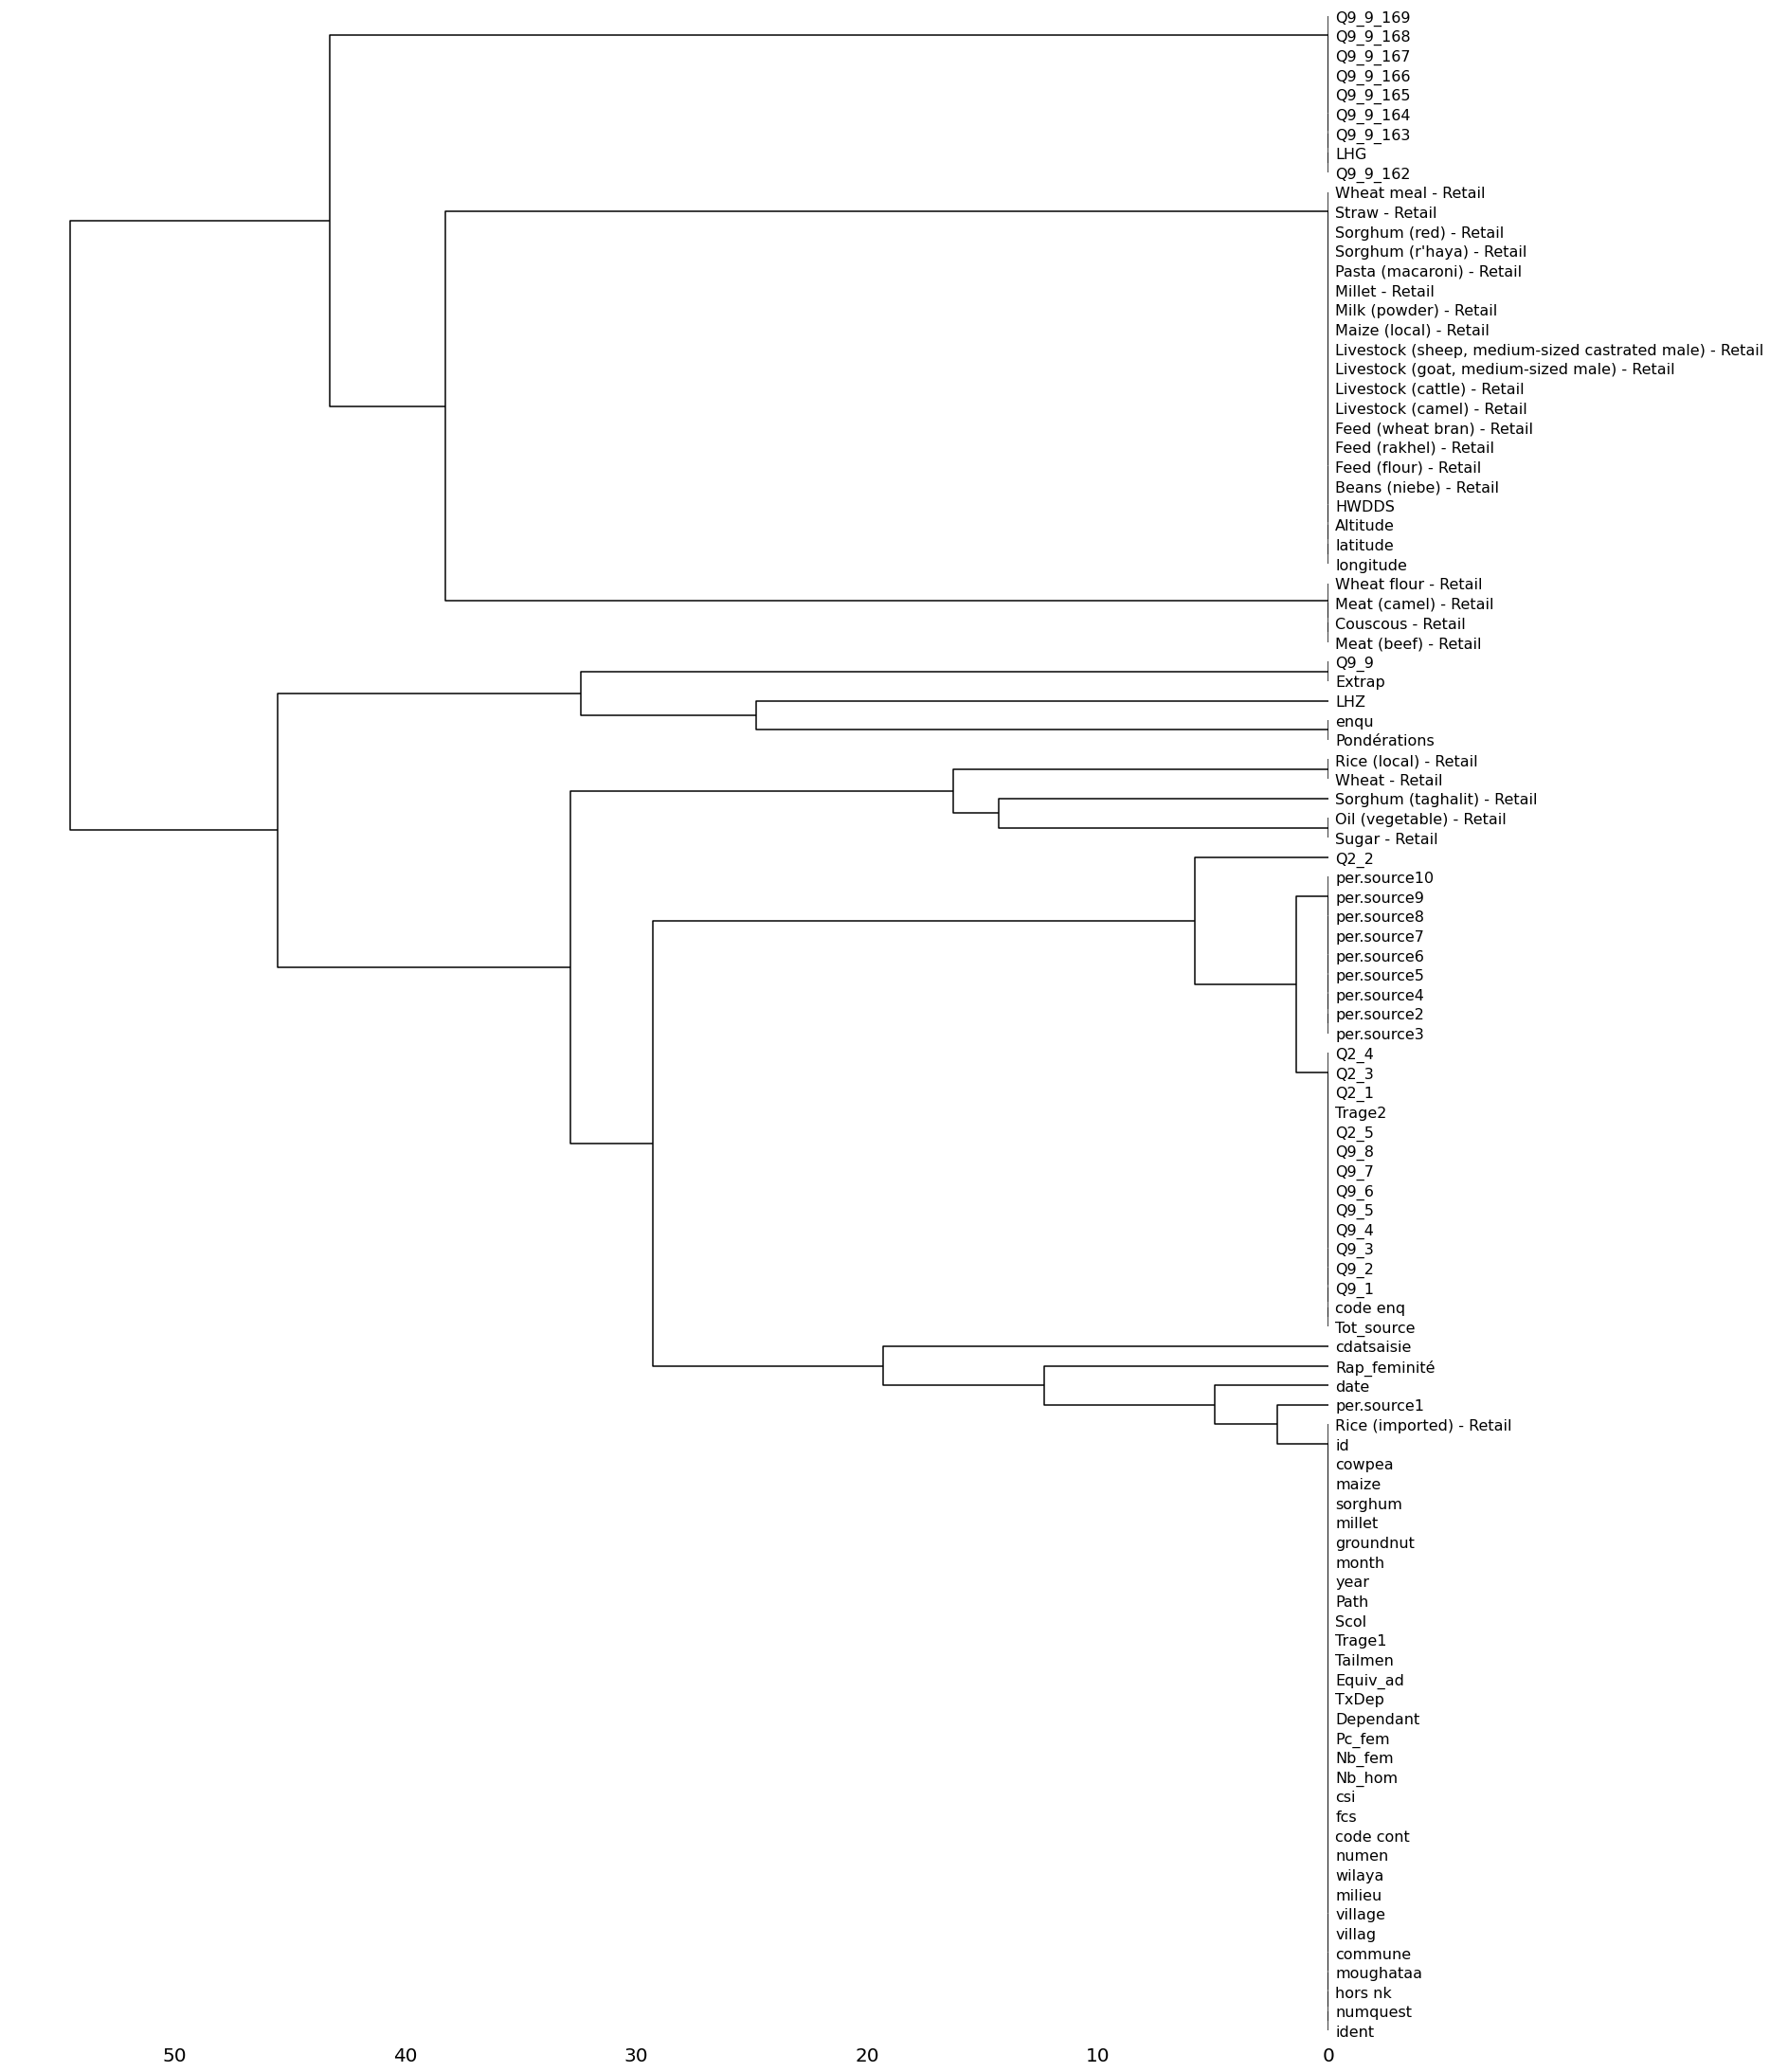

In [93]:
df_missing_lat_lon = df_aggregated_file.loc[df_aggregated_file["latitude"].isnull()].copy()
msno.dendrogram(df_missing_lat_lon)

No correlation between missing latitude longitude and missing village or other geographical information.

Nevertheless, moughataa column, villag, village or other have missing values too. Let's see if we can have a column that is entirely filled in one of these.

### Moughataas cleaning

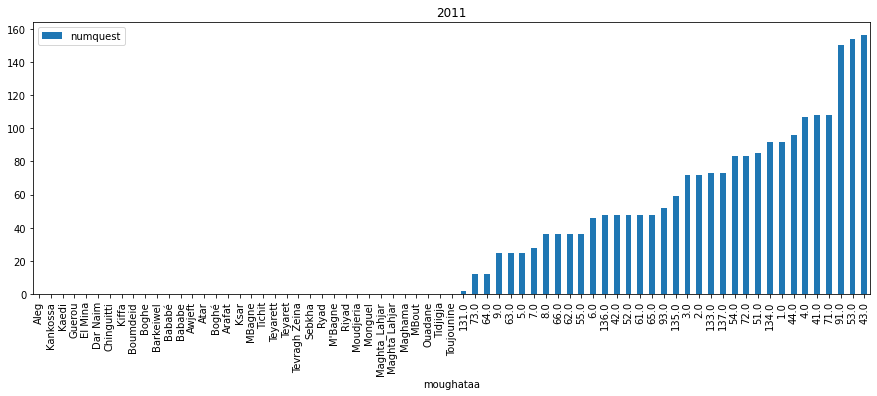

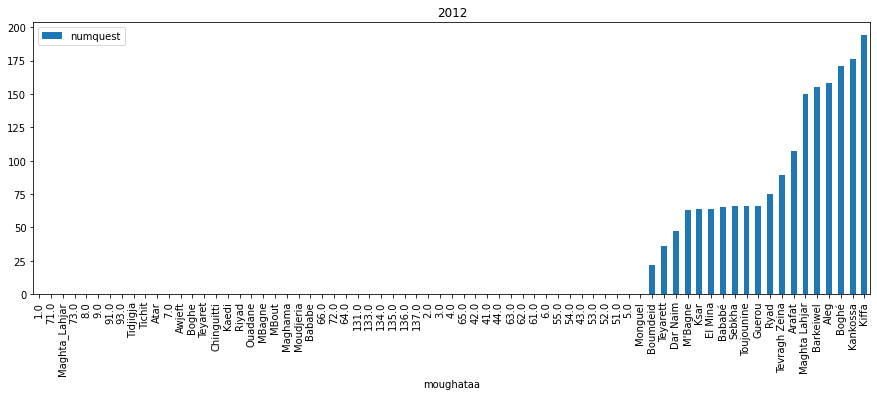

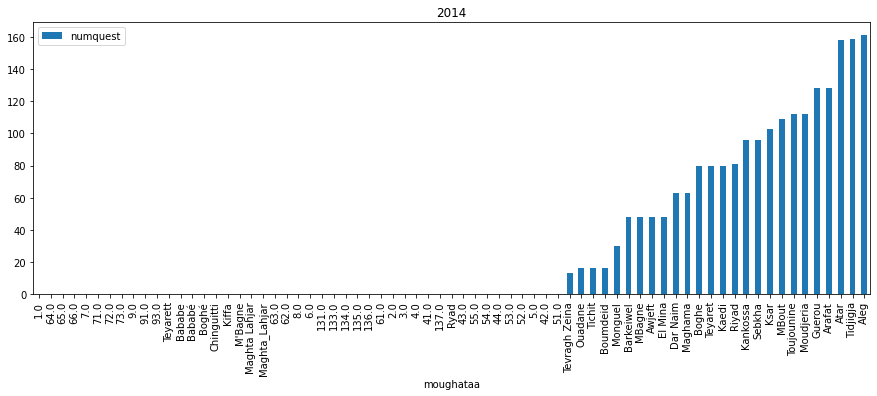

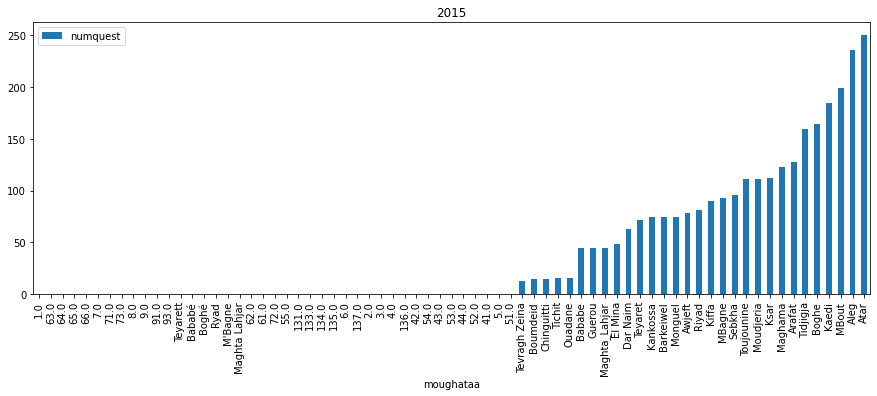

In [94]:
for year in df_aggregated_file["year"].unique():
    tmp_df = df_aggregated_file.loc[df_aggregated_file["year"]==year]
    tmp_df = pd.DataFrame(tmp_df.groupby("moughataa").count()[["numquest"]]).sort_values(by=["numquest"])
    tmp_df.plot(kind='bar', figsize=(15, 5), title=year)

Etendue des valeurs de lat-lon pour une moughataa :

In [102]:
moughataa_etendue = pd.DataFrame(df_aggregated_file.groupby(by=["moughataa"]).
                      agg({'latitude':['min', 'max'],
                          'longitude':['min', 'max'],
                          'Altitude':['min', 'max'],}))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(moughataa_etendue)

                latitude             longitude               Altitude  \
                     min        max        min        max         min   
moughataa                                                               
1.0                  NaN        NaN        NaN        NaN         NaN   
131.0                NaN        NaN        NaN        NaN         NaN   
133.0                NaN        NaN        NaN        NaN         NaN   
134.0                NaN        NaN        NaN        NaN         NaN   
135.0                NaN        NaN        NaN        NaN         NaN   
136.0                NaN        NaN        NaN        NaN         NaN   
137.0                NaN        NaN        NaN        NaN         NaN   
2.0                  NaN        NaN        NaN        NaN         NaN   
3.0                  NaN        NaN        NaN        NaN         NaN   
4.0                  NaN        NaN        NaN        NaN         NaN   
41.0                 NaN        NaN        NaN     

Cela ne nous aide pas.

### Communes cleaning

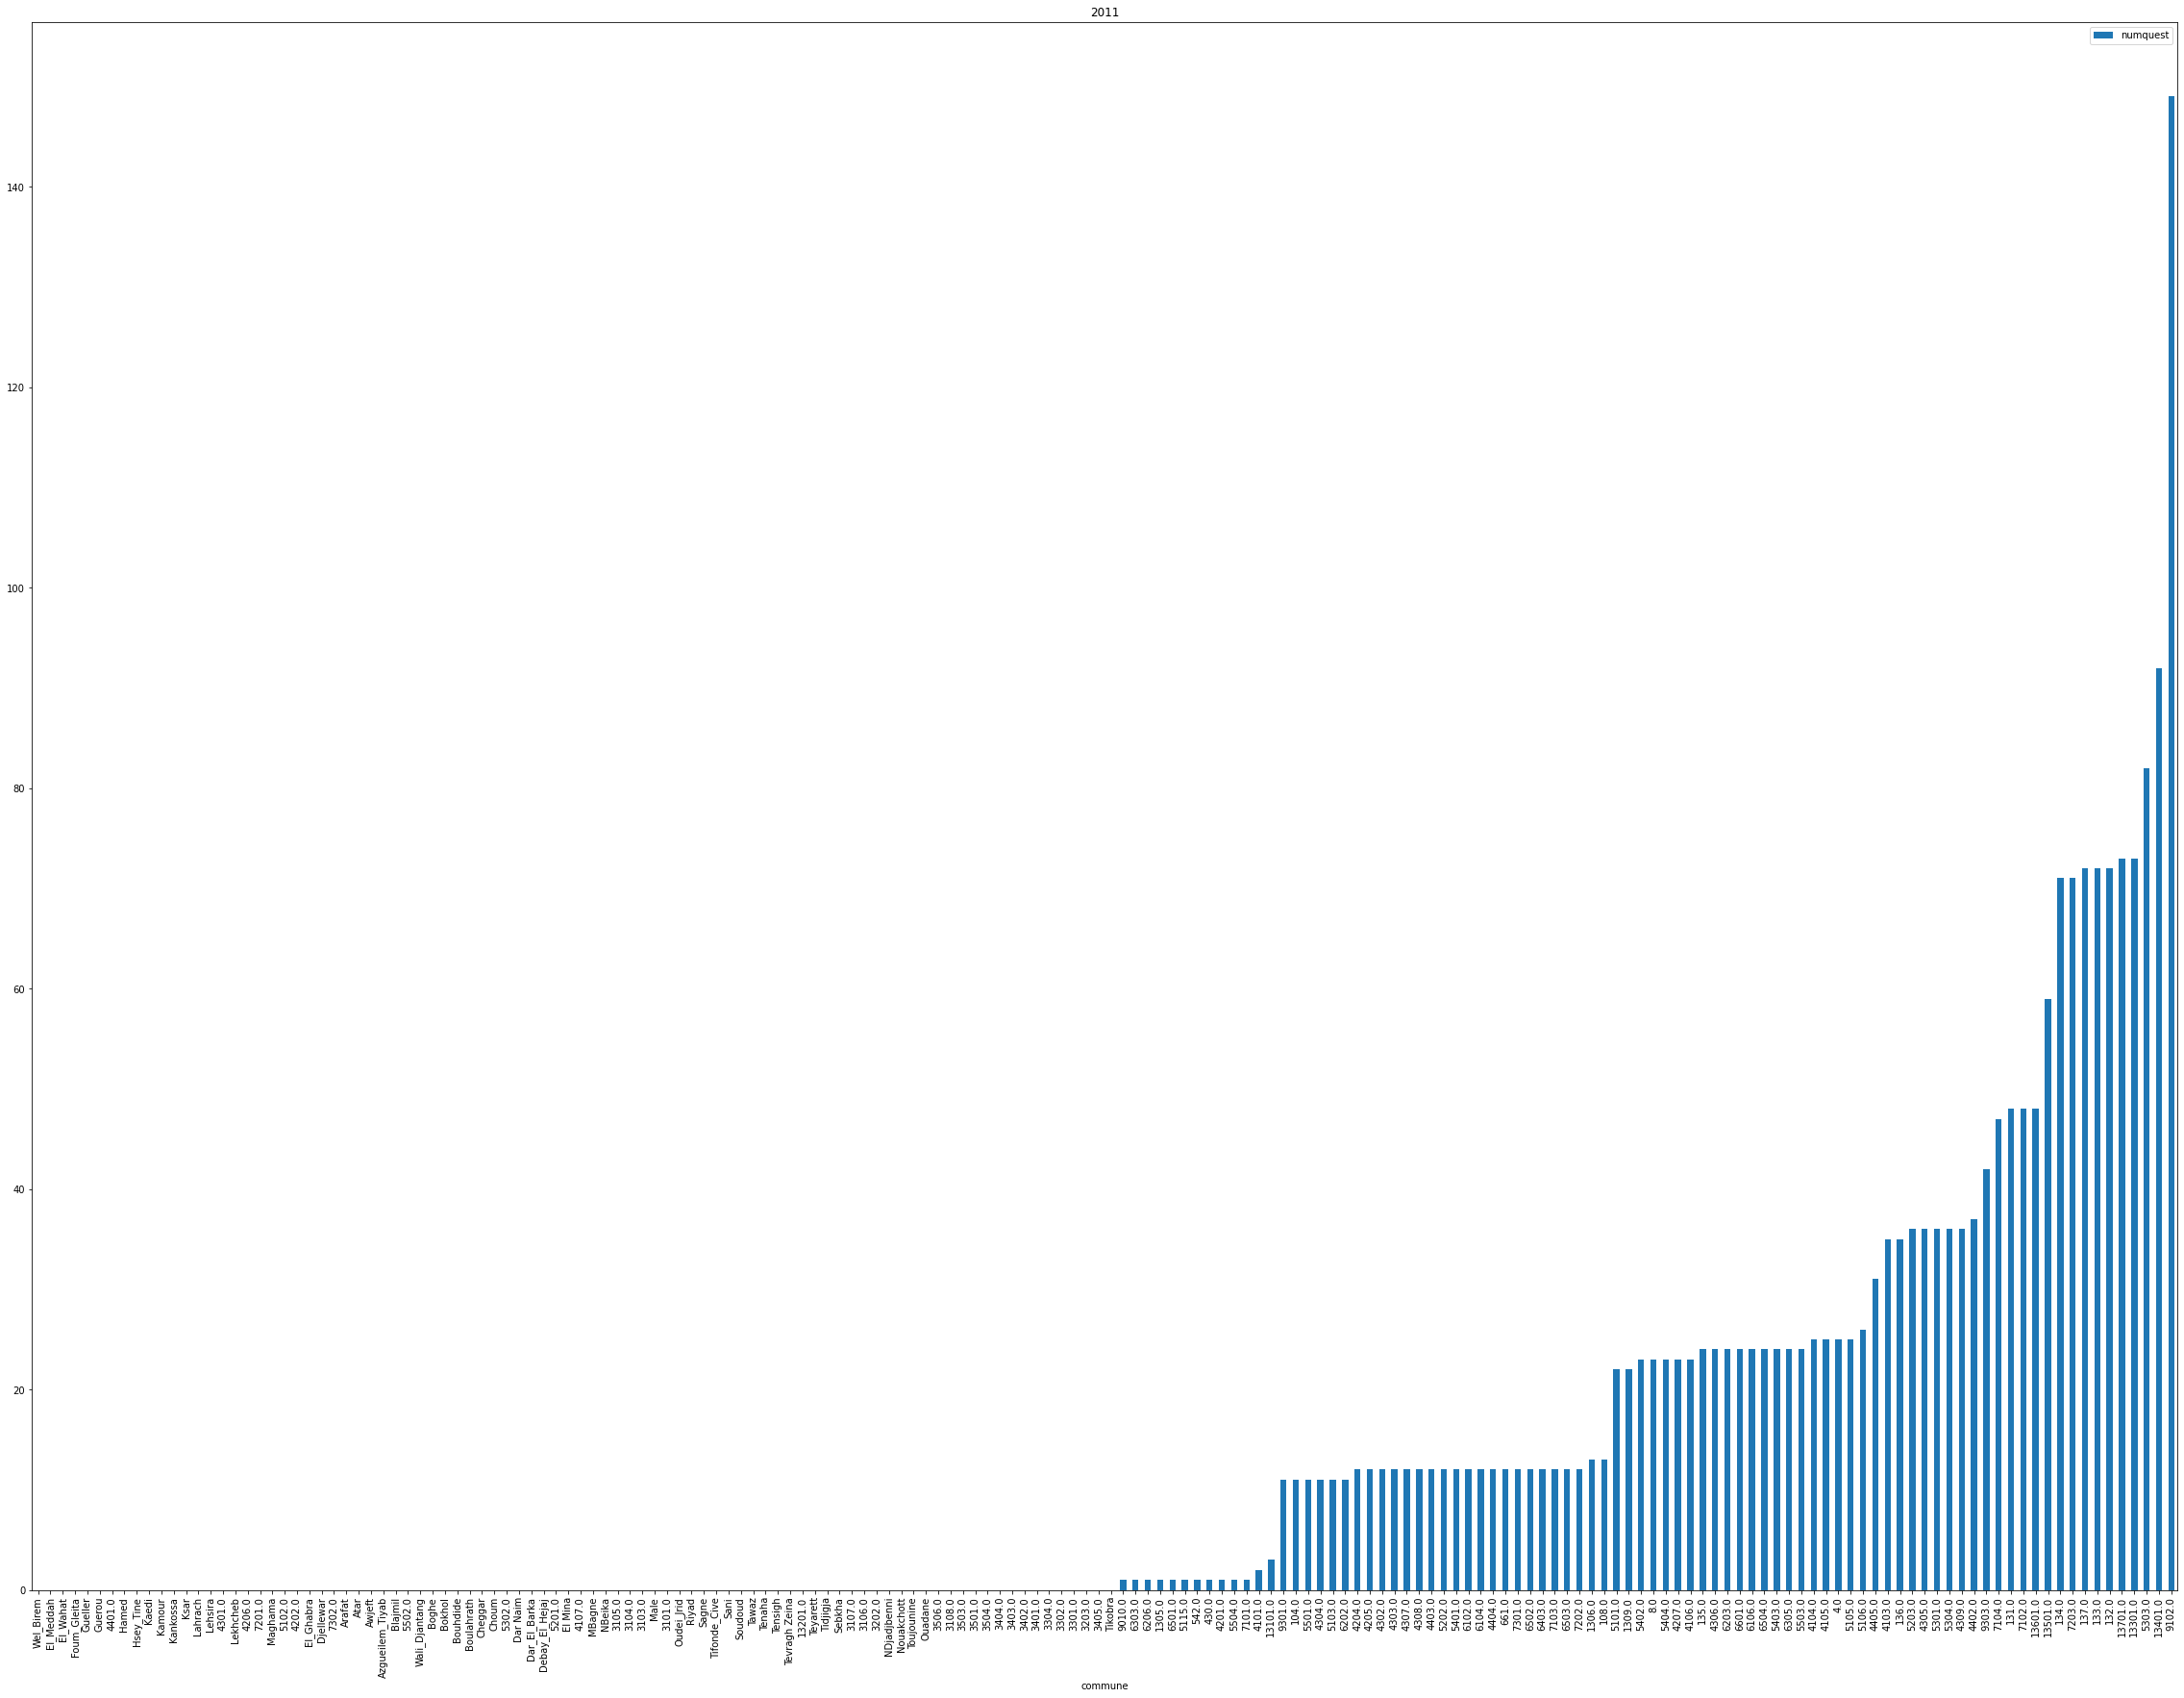

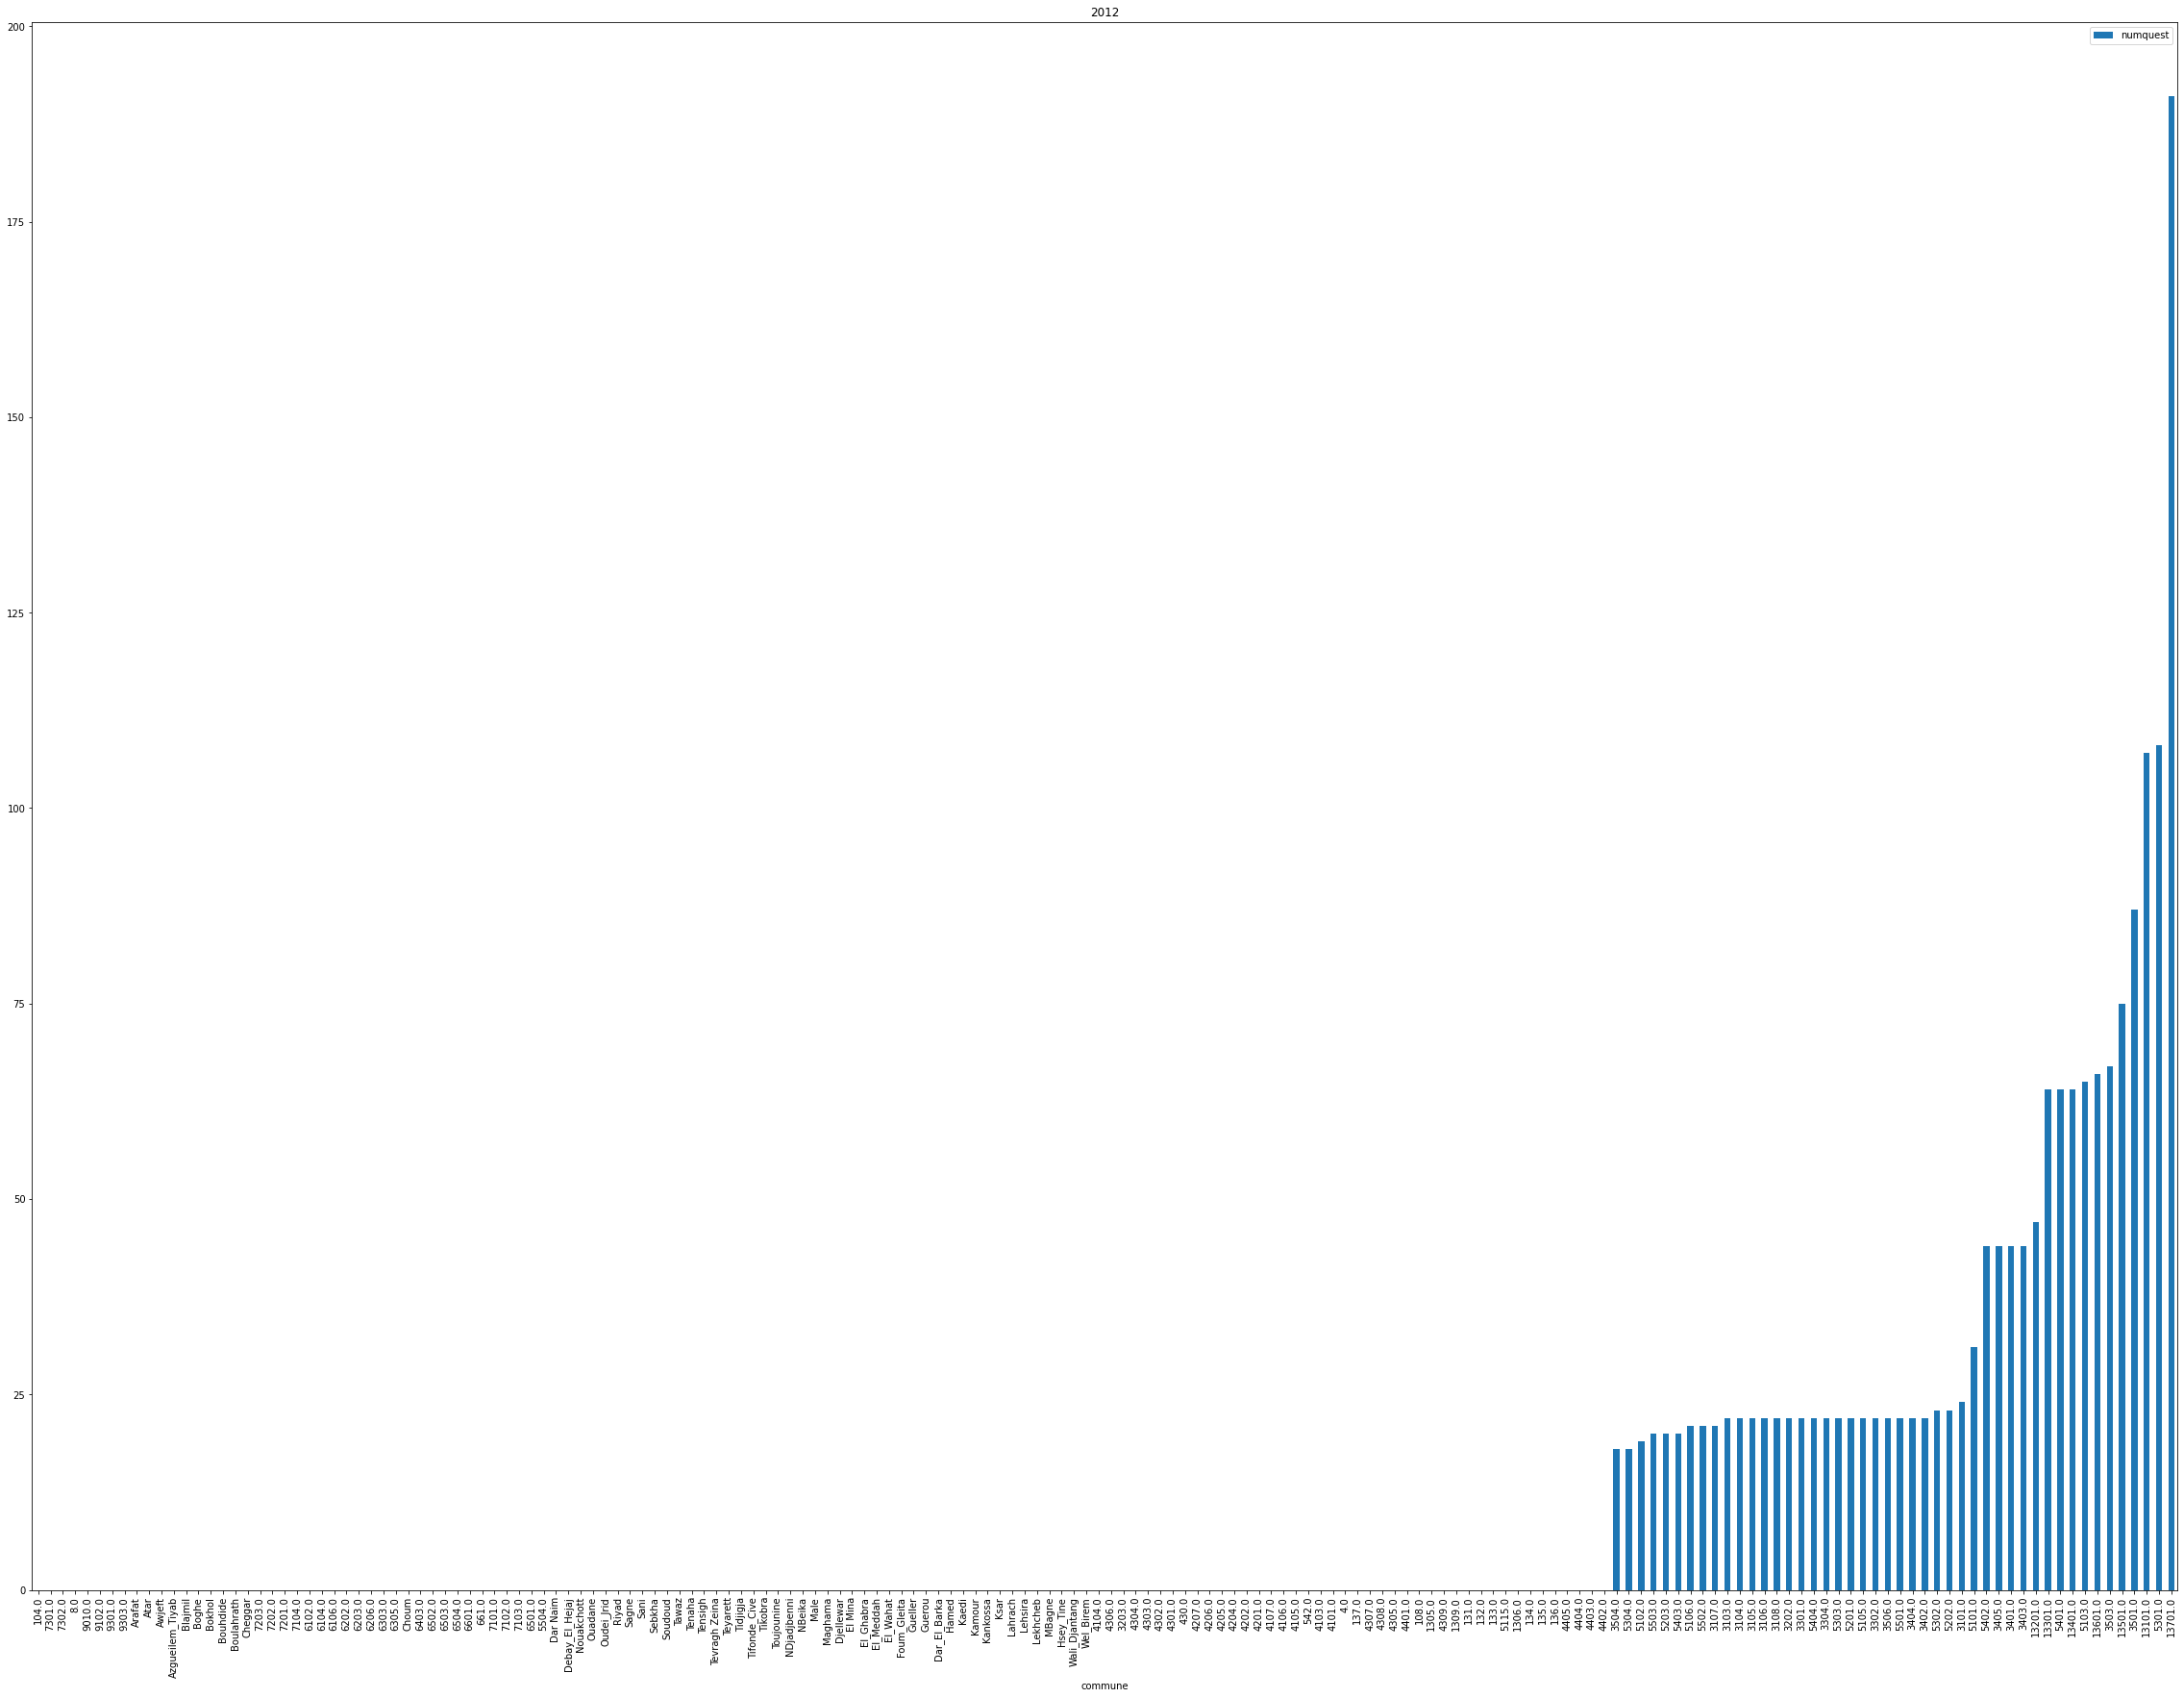

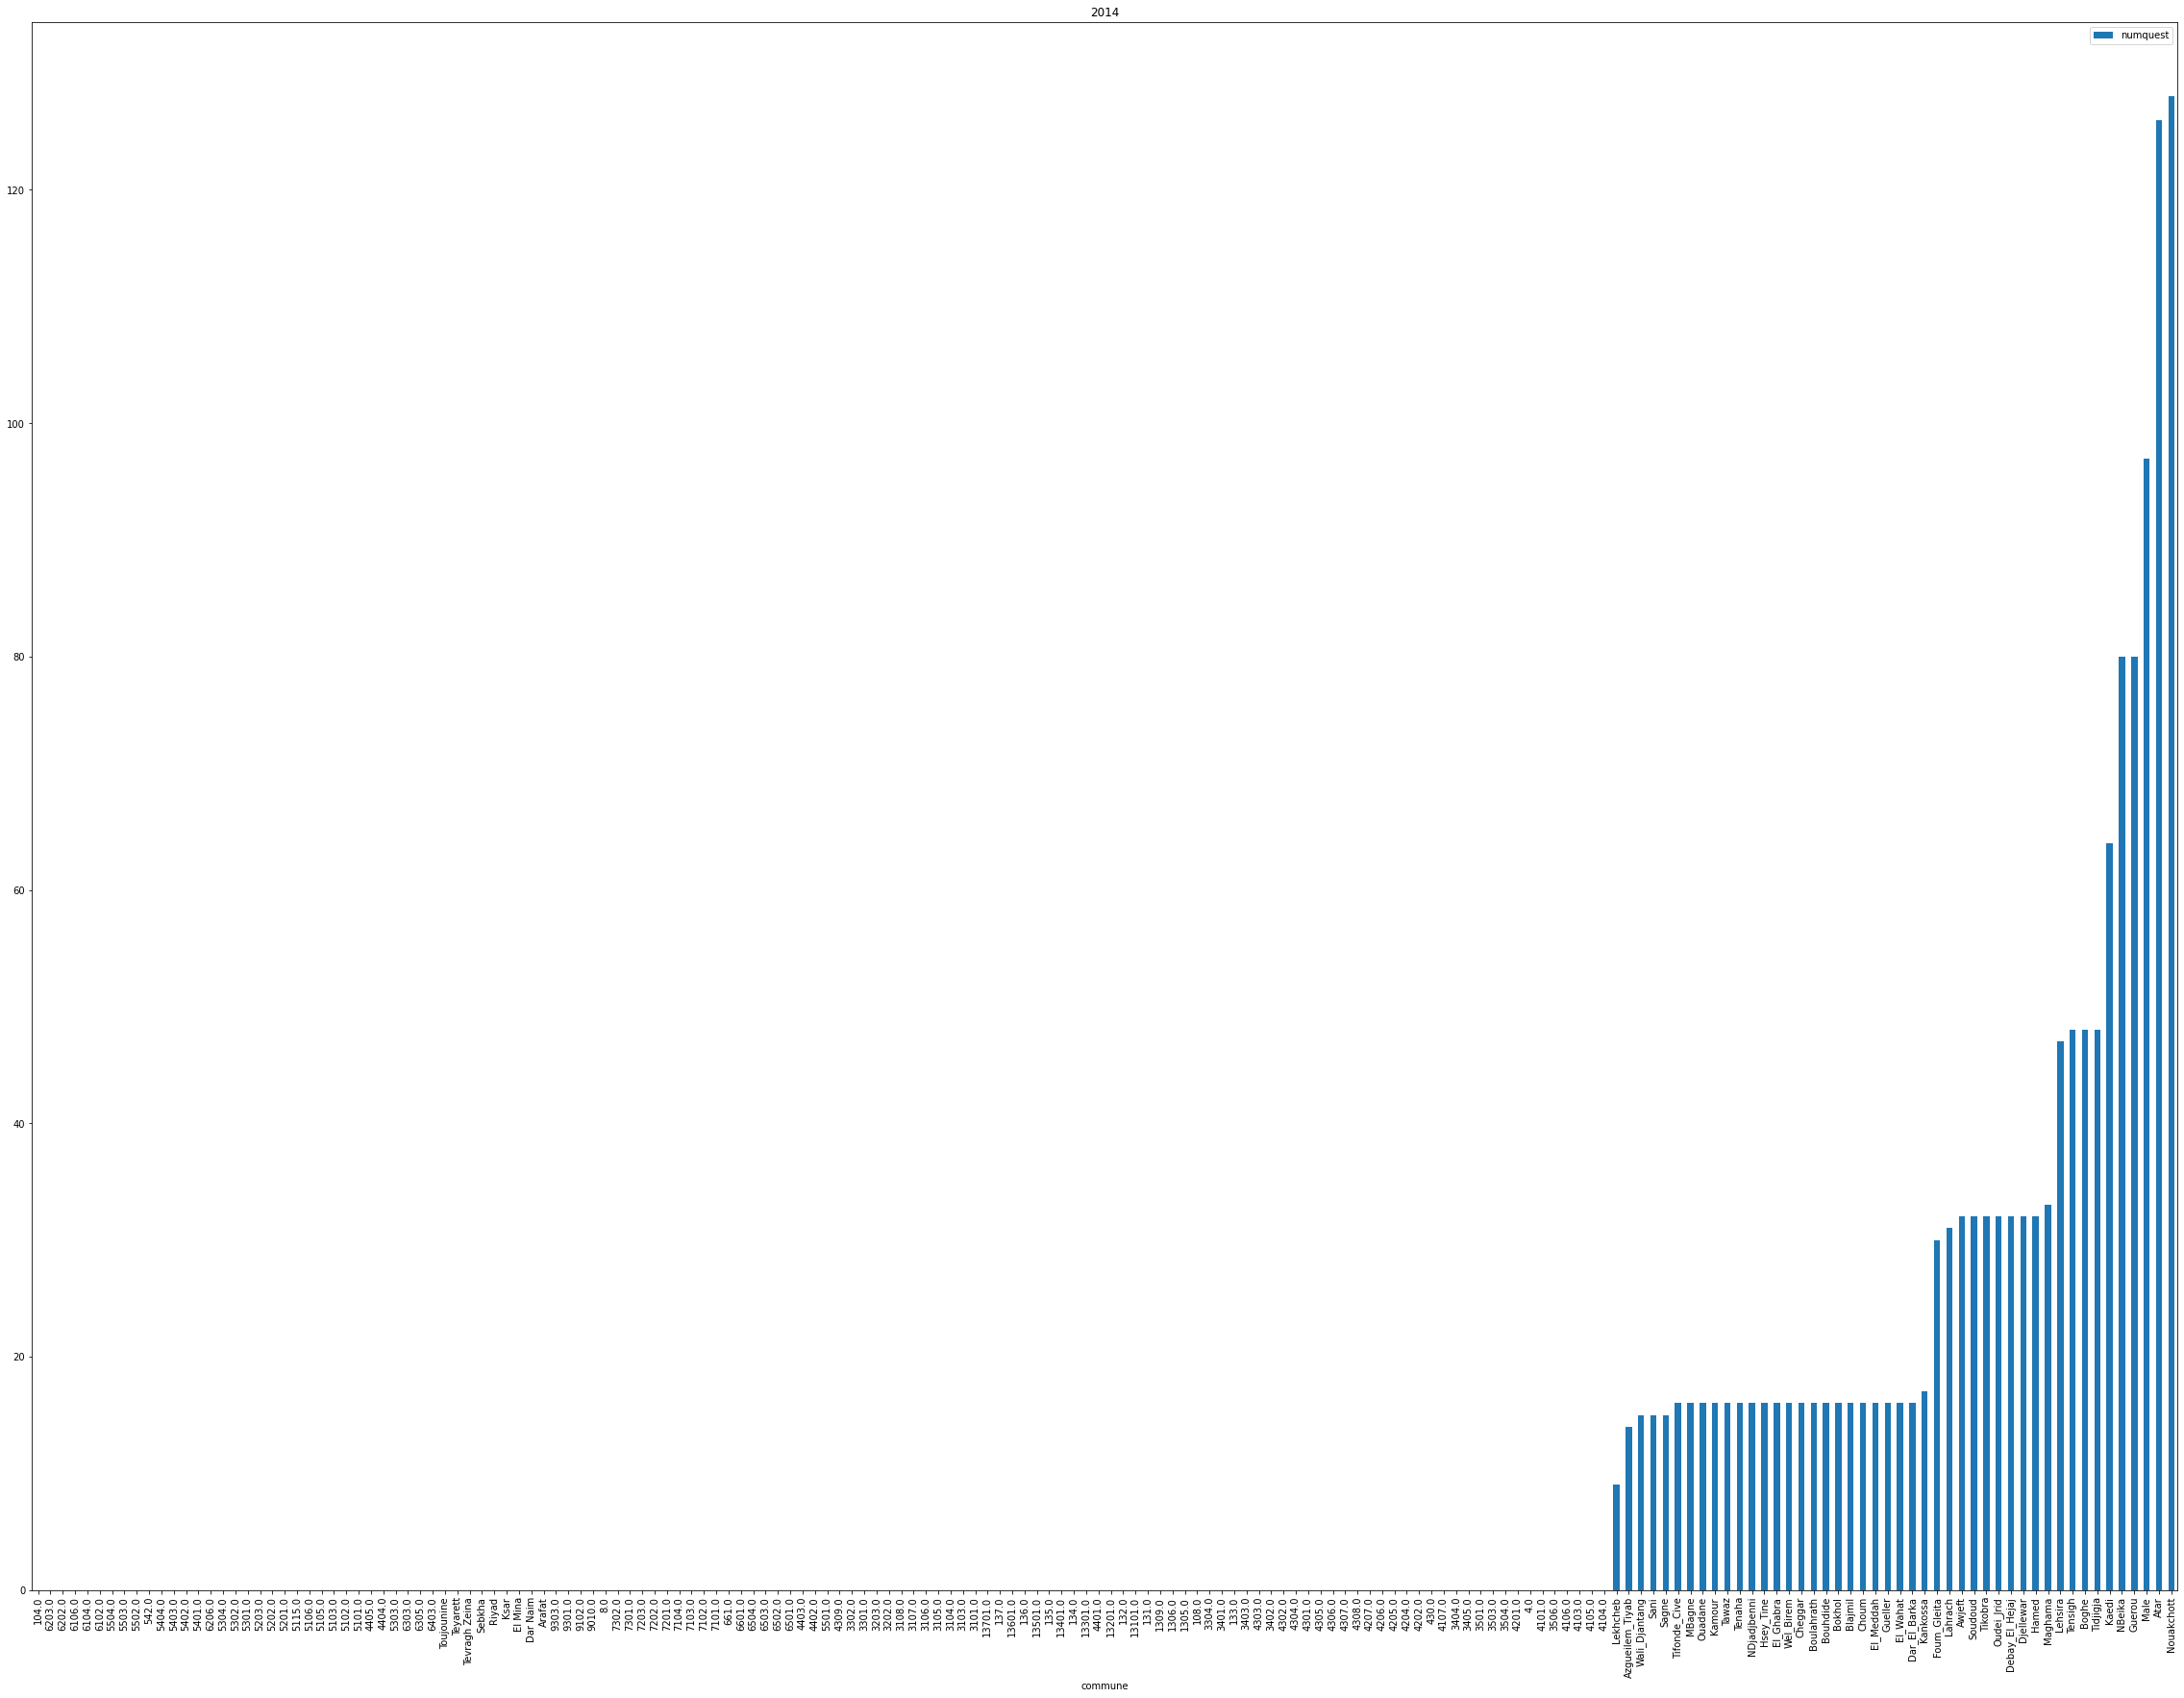

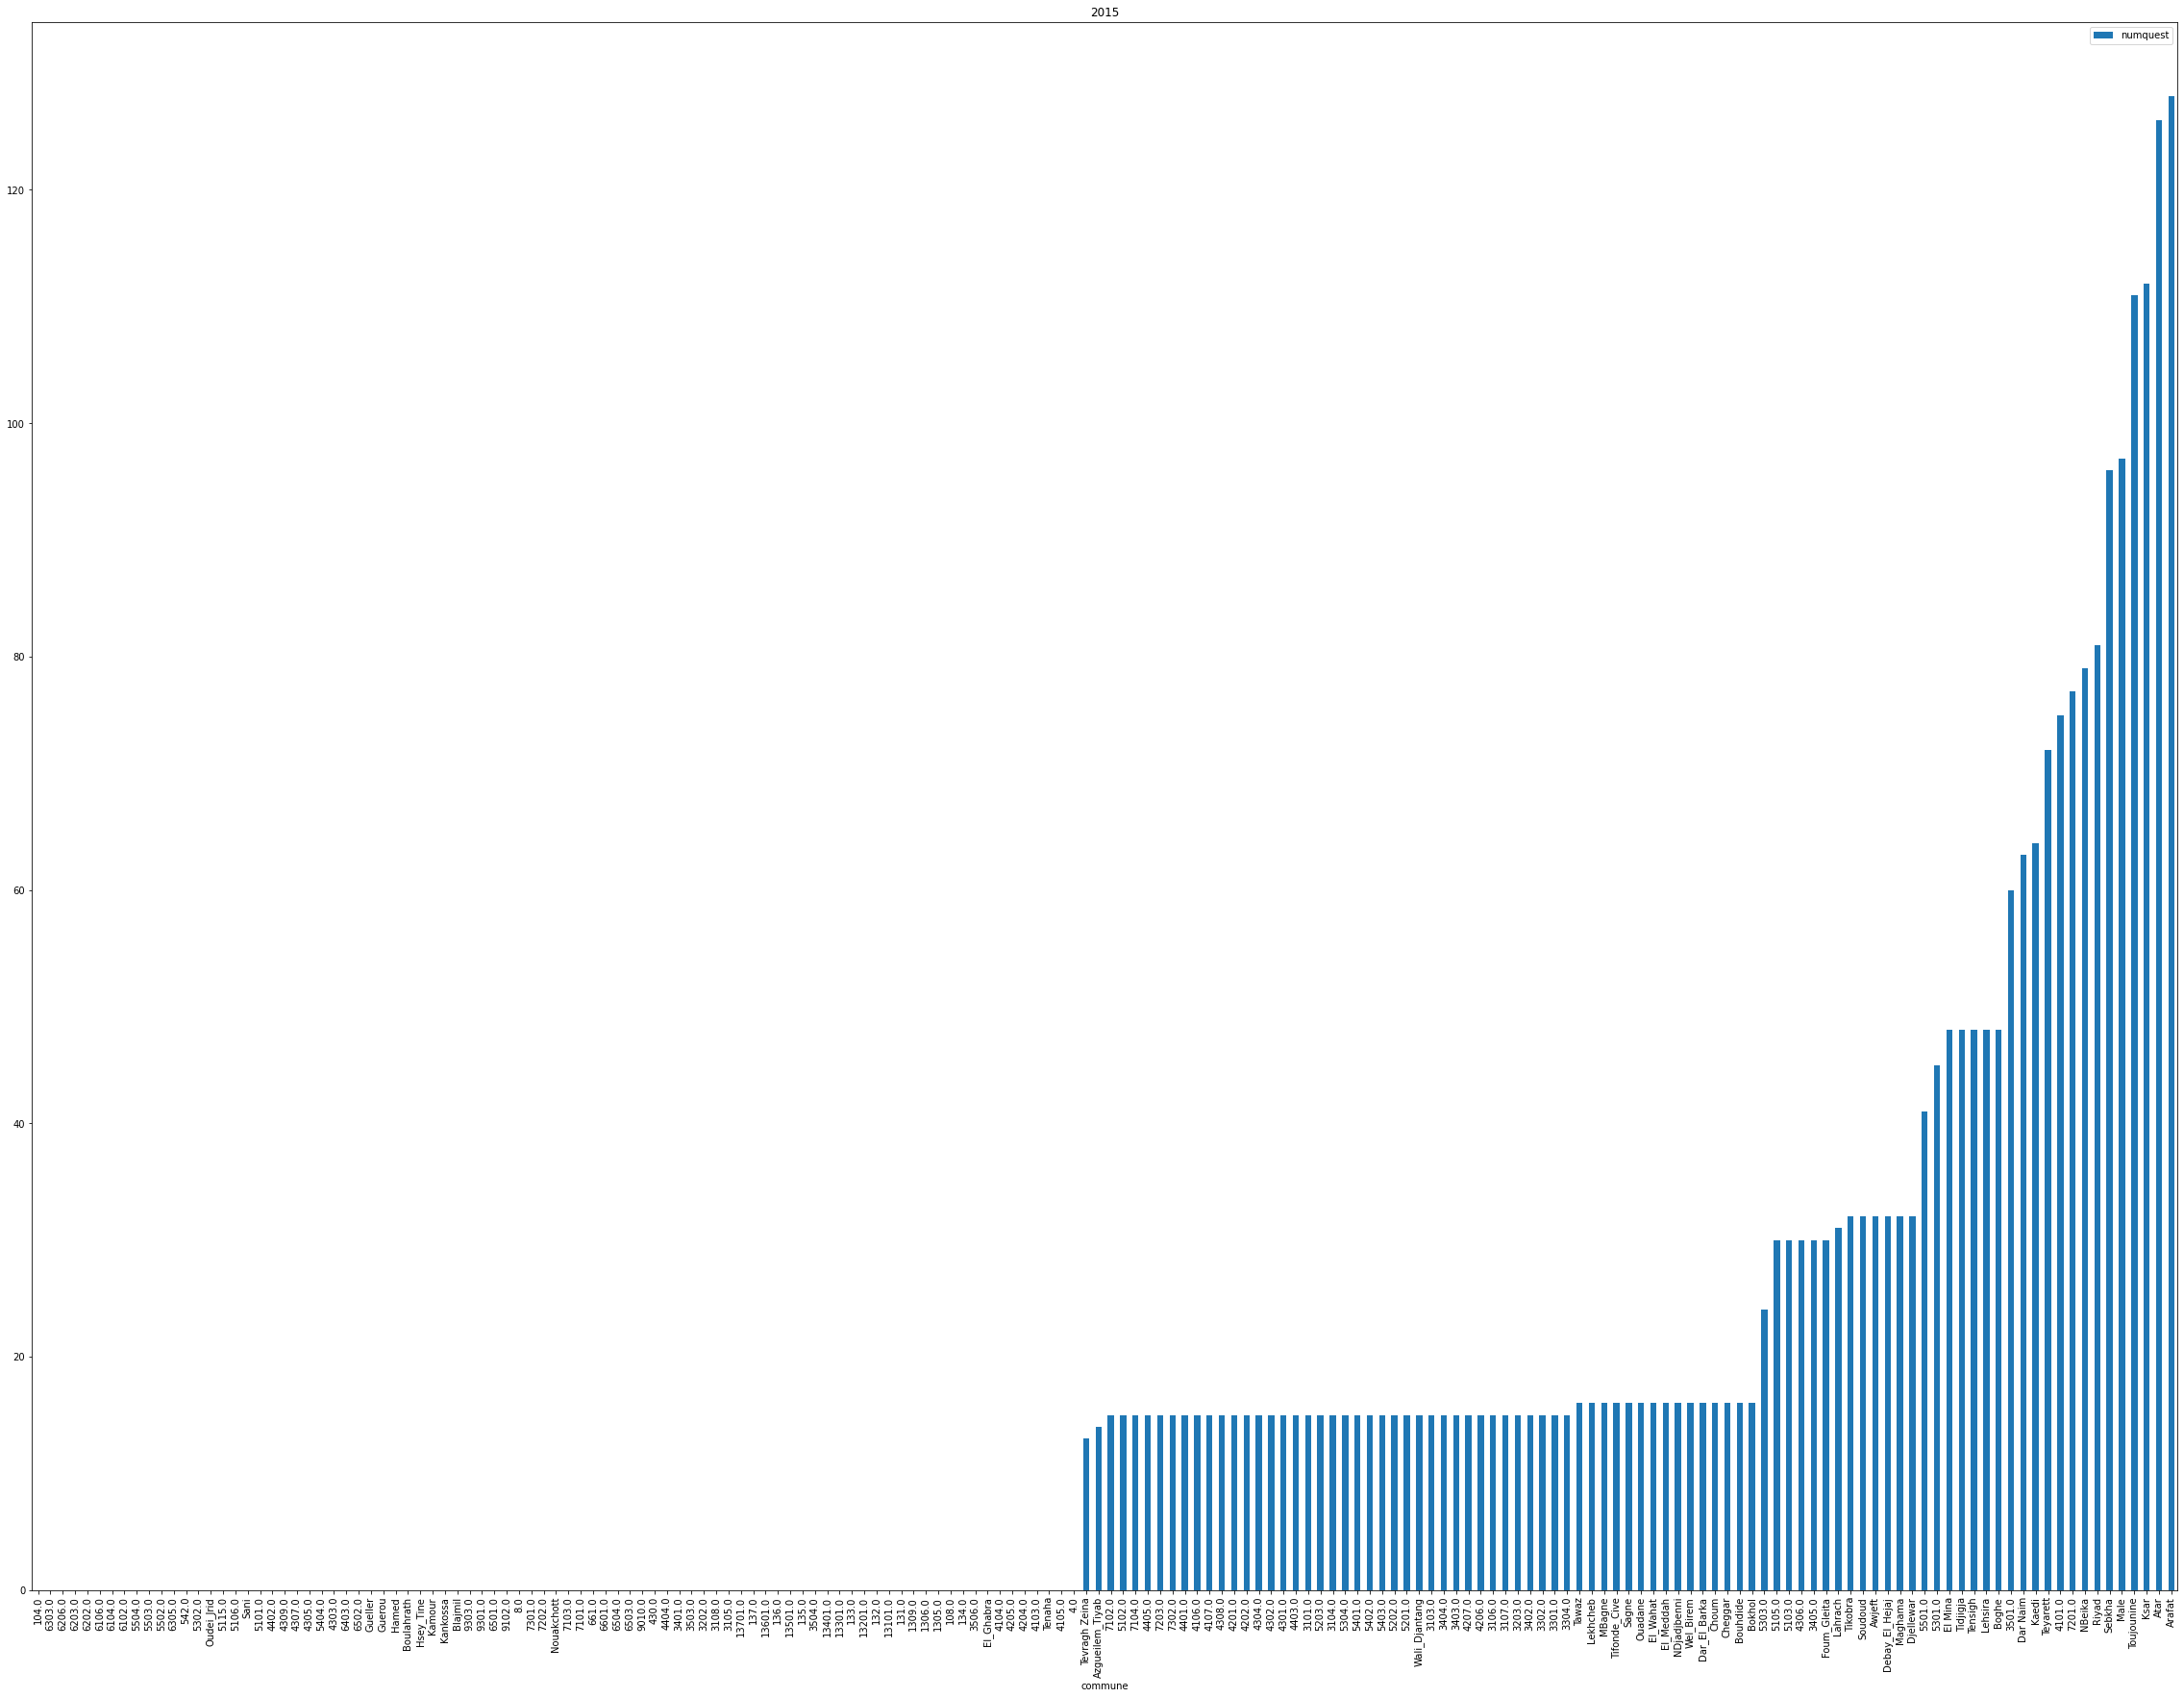

In [7]:
for year in df_aggregated_file["year"].unique():
    tmp_df = df_aggregated_file.loc[df_aggregated_file["year"]==year]
    tmp_df = pd.DataFrame(tmp_df.groupby("commune").count()[["numquest"]]).sort_values(by=["numquest"])
    tmp_df.plot(kind='bar', figsize=(40, 30), title=year)

Prédominance de Nouakchott, mais elle ne semble pas avoir le même code tous les ans. Difficile d'extrapoler.

Etendue des valeurs de lat-lon pour une commune :

In [104]:
commune_etendue = pd.DataFrame(df_aggregated_file.groupby(by=["commune"]).
                      agg({'latitude':['min', 'max'],
                          'longitude':['min', 'max'],
                          'Altitude':['min', 'max'],}))
with pd.option_context('display.max_rows', None, 'display.max_columns', None):
    print(commune_etendue)

                  latitude             longitude               Altitude  \
                       min        max        min        max         min   
commune                                                                   
104.0                  NaN        NaN        NaN        NaN         NaN   
108.0                  NaN        NaN        NaN        NaN         NaN   
1305.0                 NaN        NaN        NaN        NaN         NaN   
1306.0                 NaN        NaN        NaN        NaN         NaN   
1309.0                 NaN        NaN        NaN        NaN         NaN   
131.0                  NaN        NaN        NaN        NaN         NaN   
13101.0                NaN        NaN        NaN        NaN         NaN   
132.0                  NaN        NaN        NaN        NaN         NaN   
13201.0                NaN        NaN        NaN        NaN         NaN   
133.0                  NaN        NaN        NaN        NaN         NaN   
13301.0                Na

### villag cleaning

villag toujours présents => on peut commencer par là pour la lat-lon.

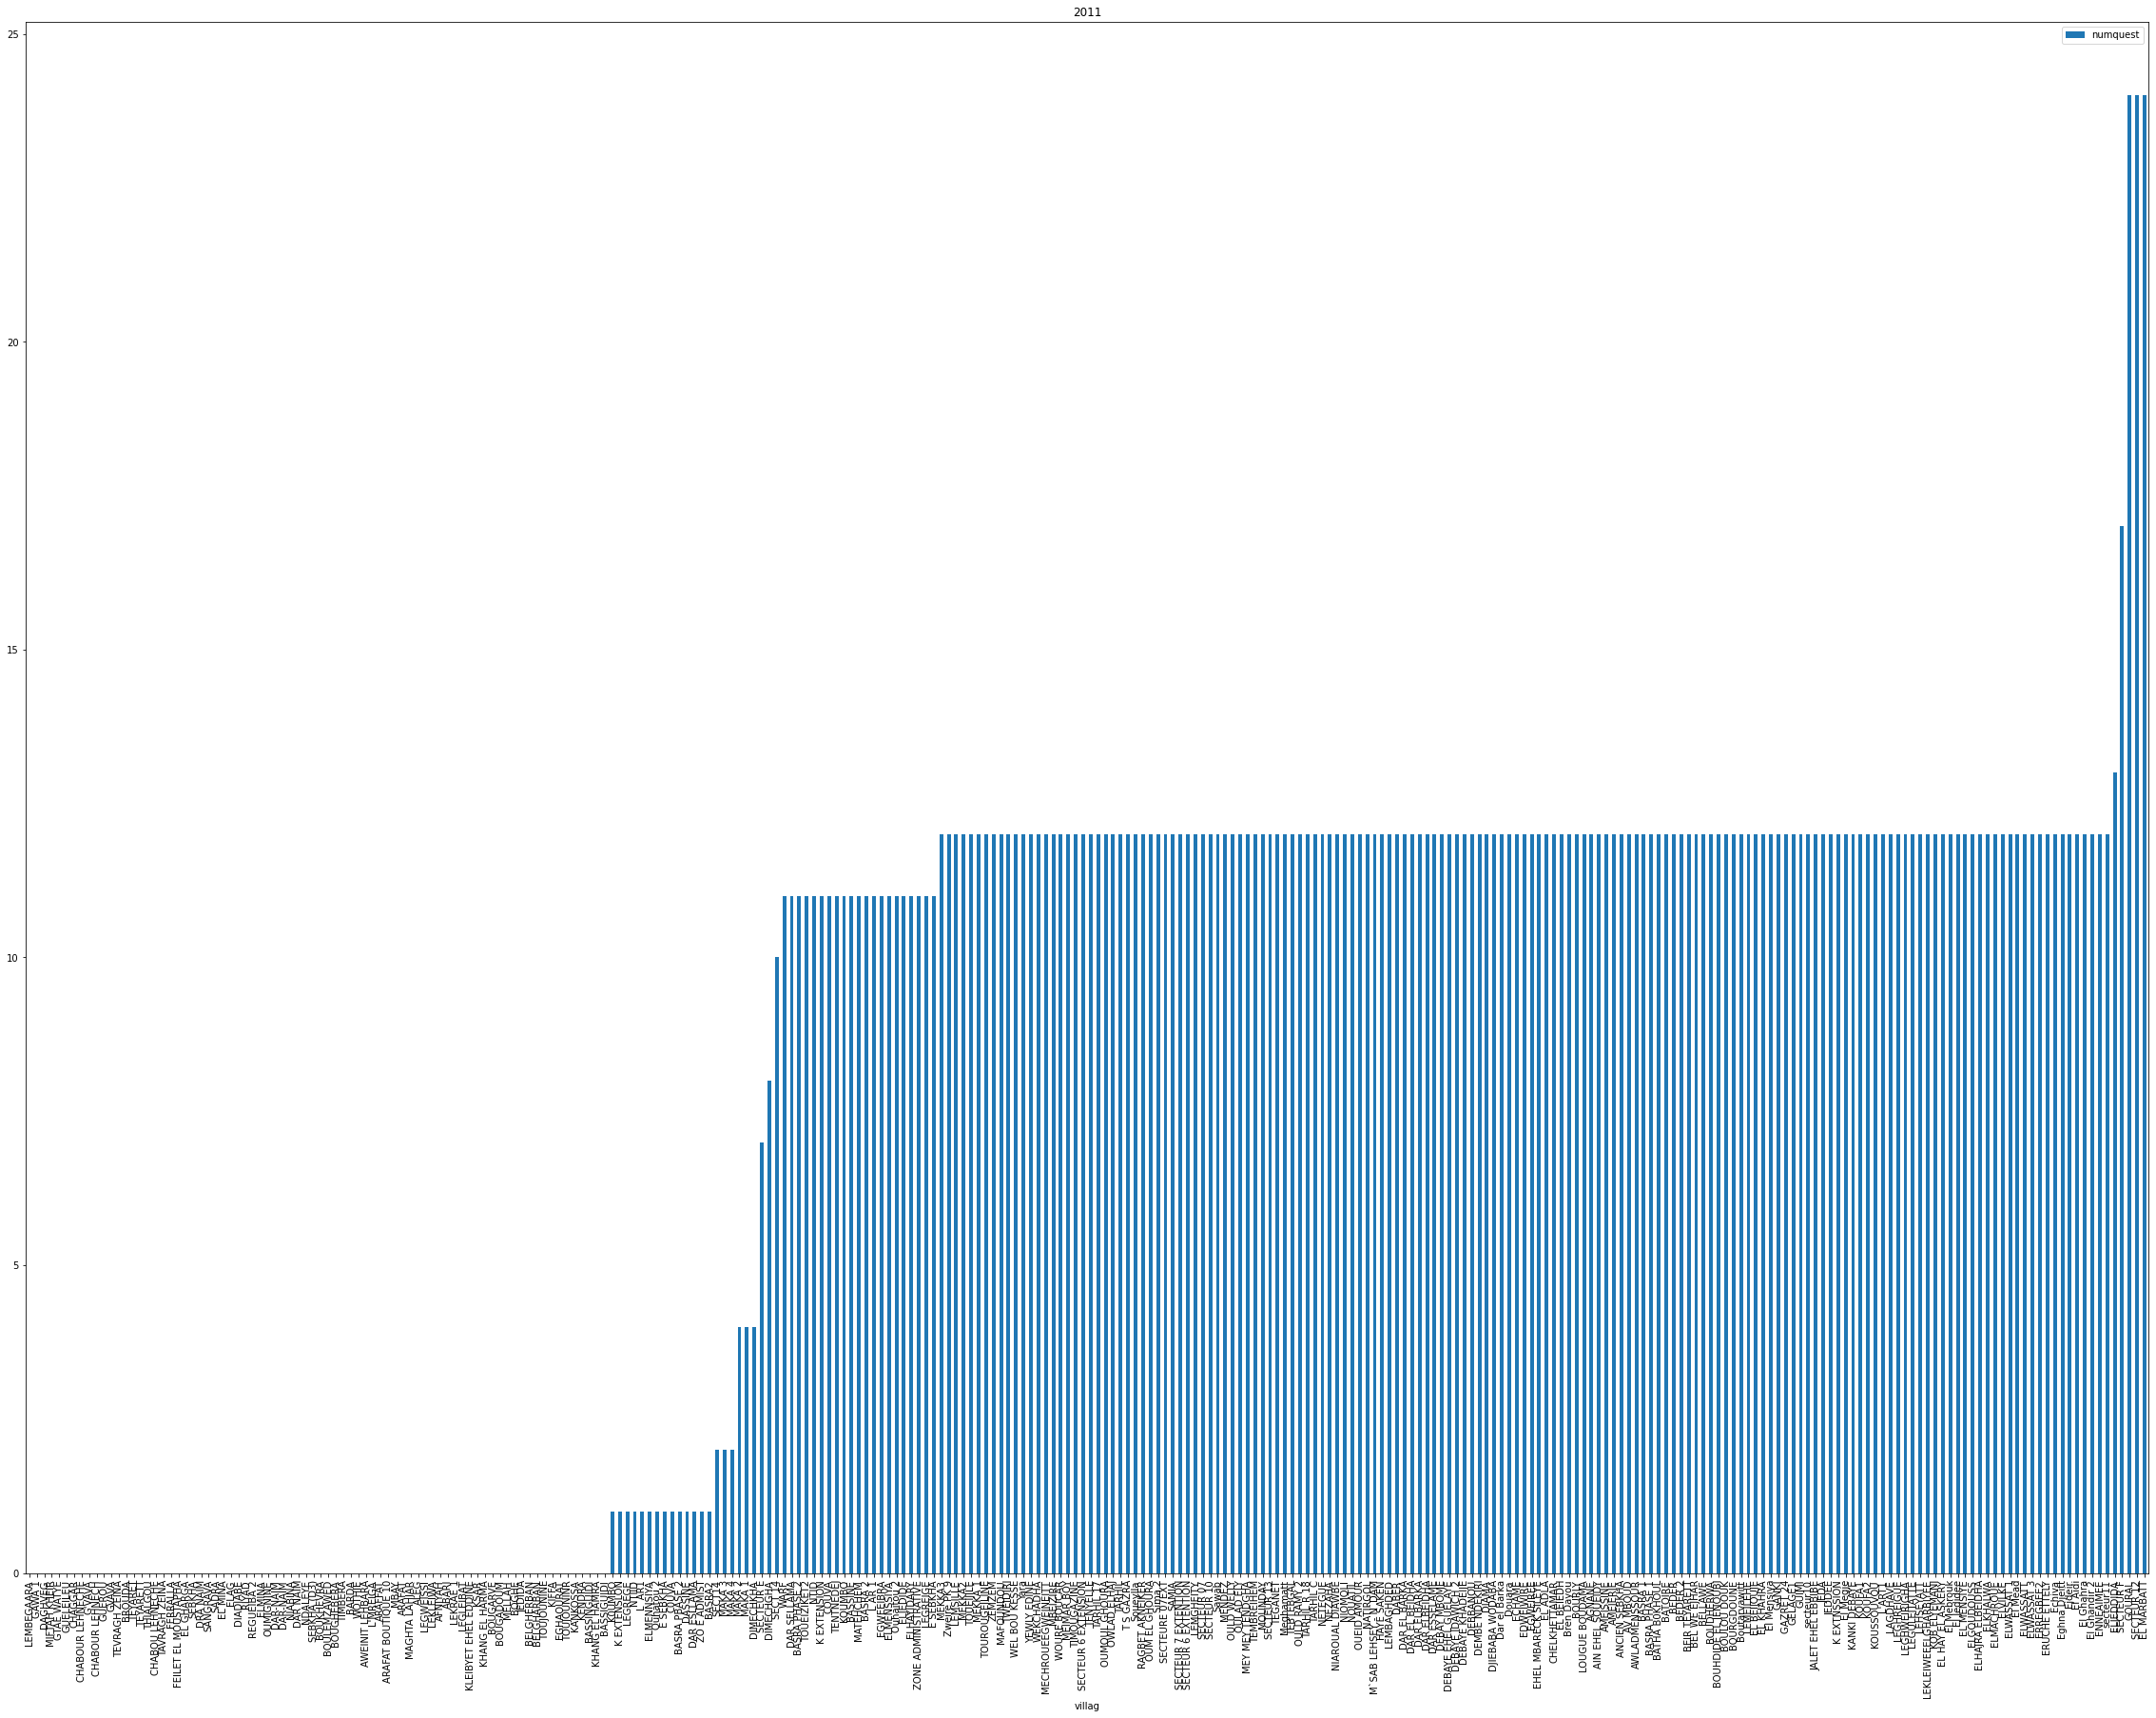

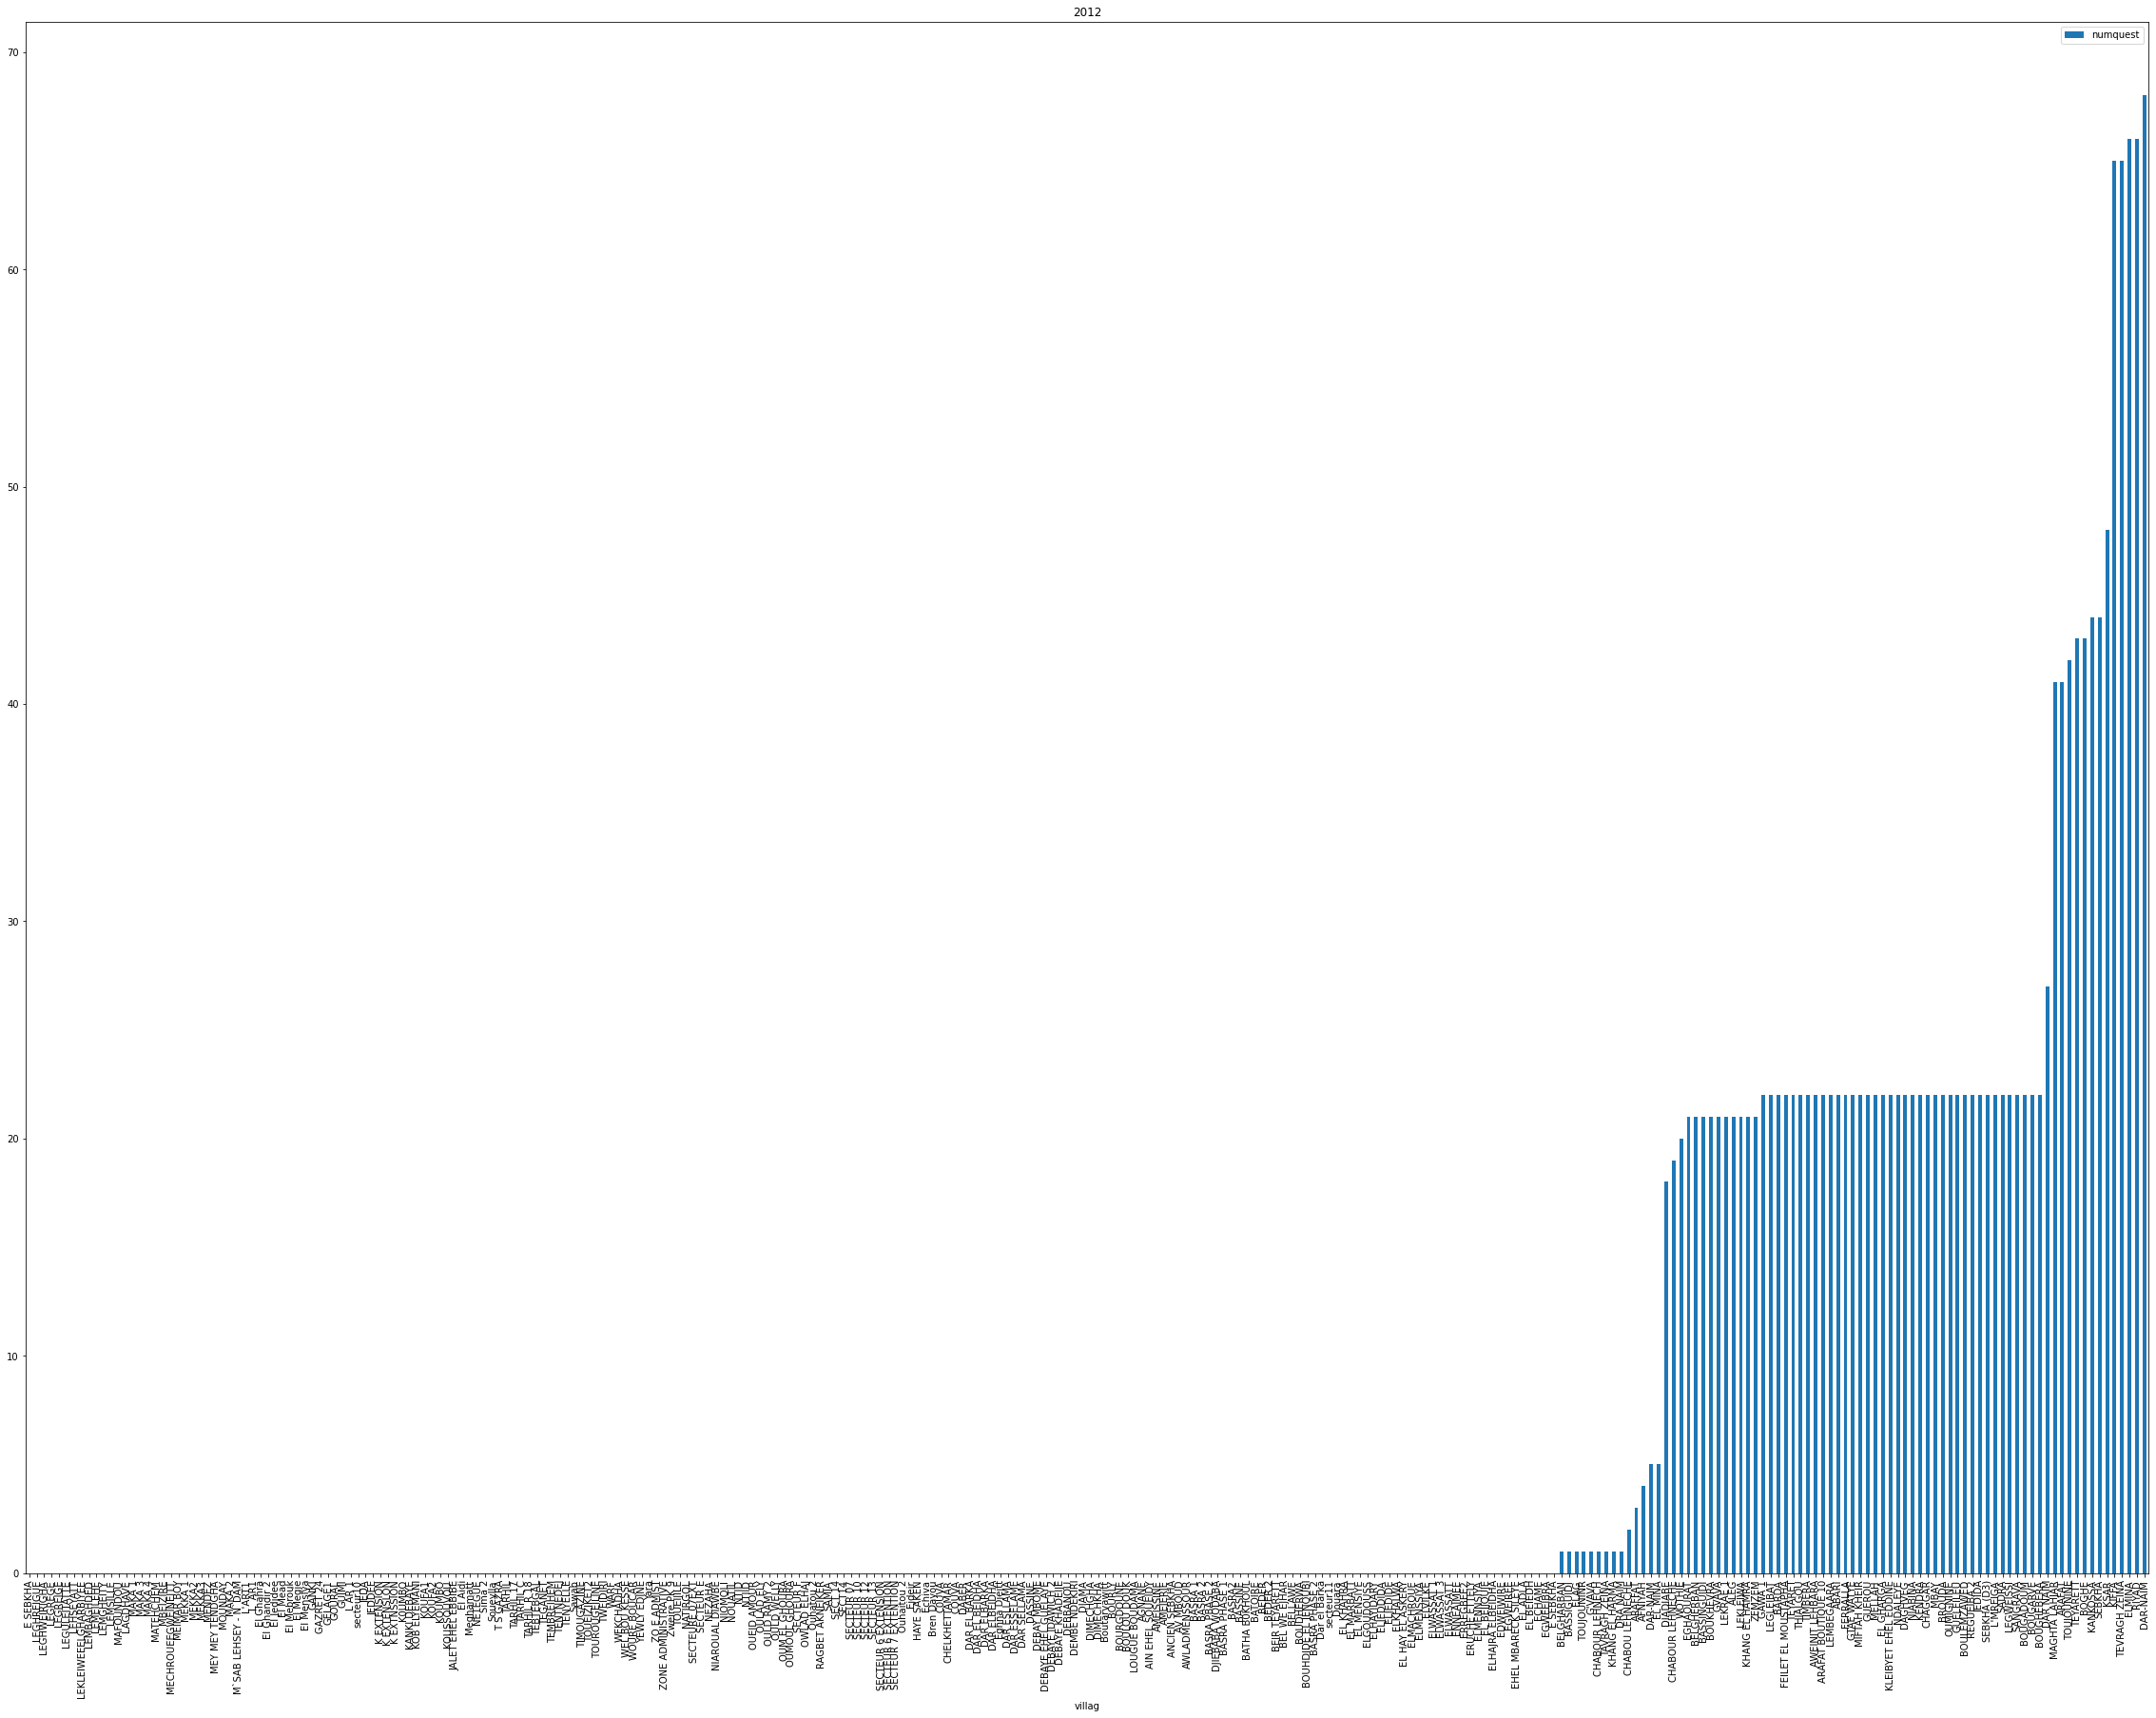

In [ ]:
for year in df_aggregated_file["year"].unique():
    tmp_df = df_aggregated_file.loc[df_aggregated_file["year"]==year]
    tmp_df = pd.DataFrame(tmp_df.groupby("villag").count()[["numquest"]]).sort_values(by=["numquest"])
    tmp_df.plot(kind='bar', figsize=(40, 30), title=year)

### village cleaning

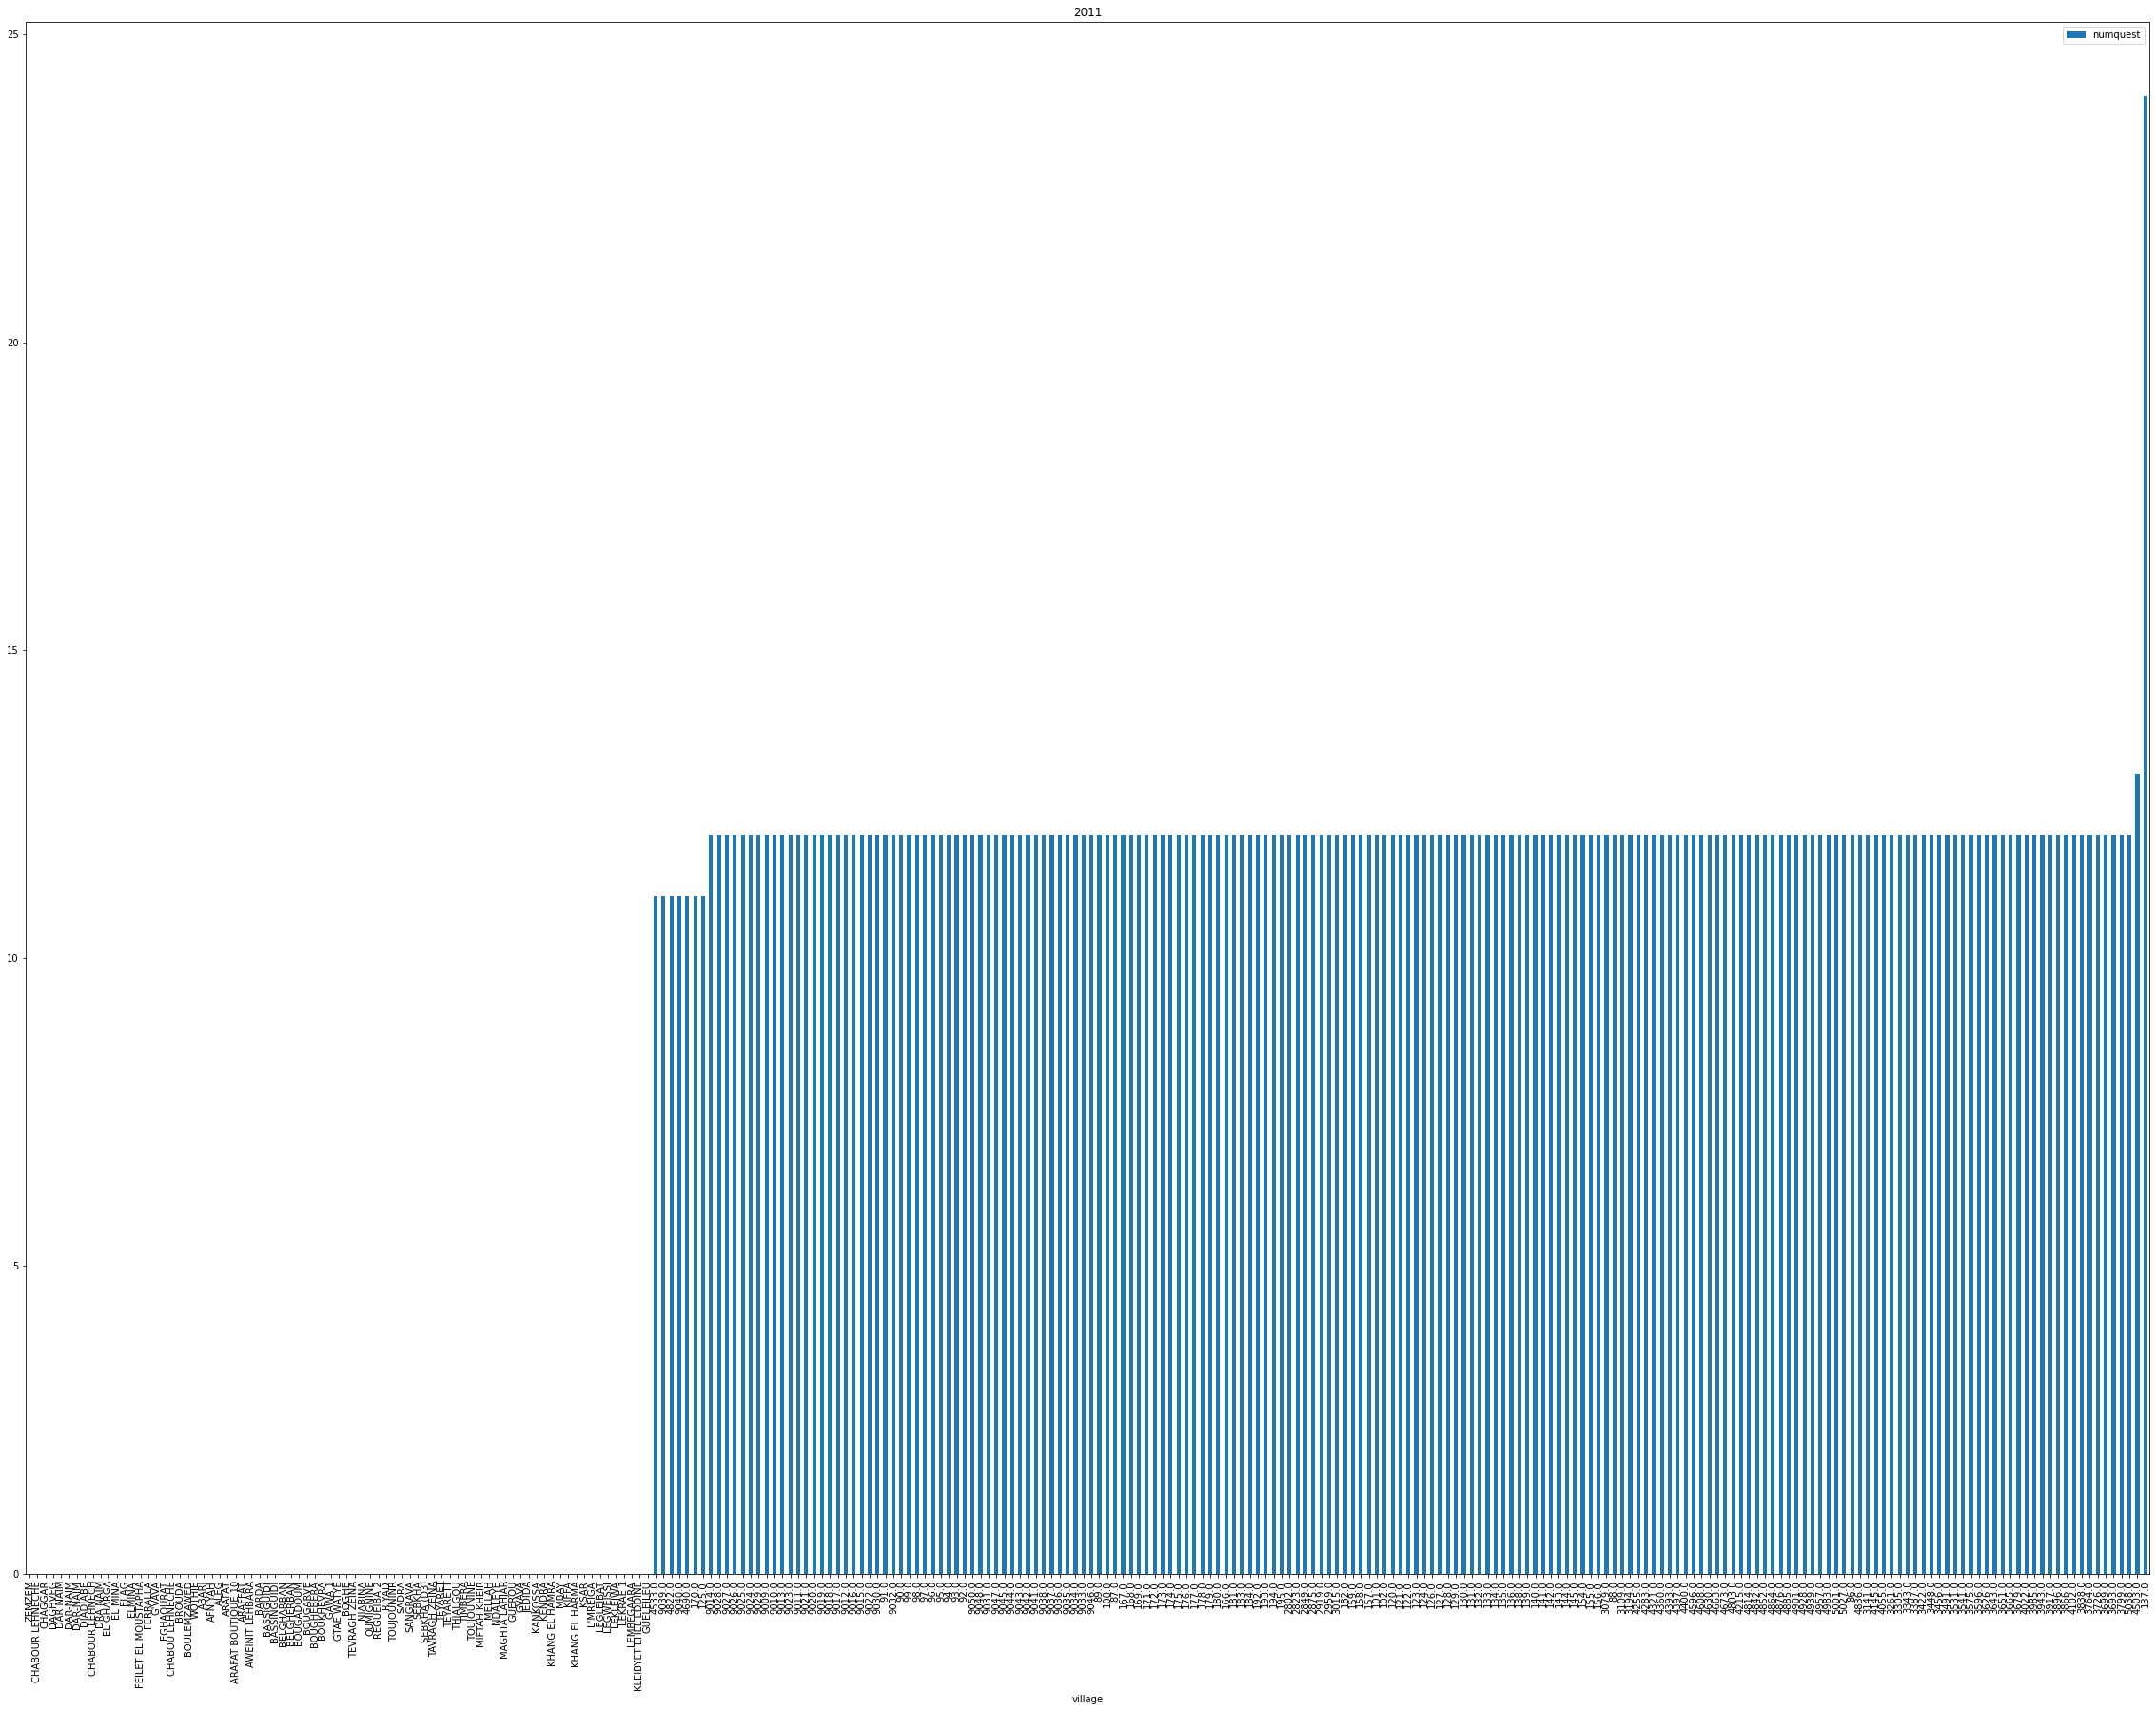

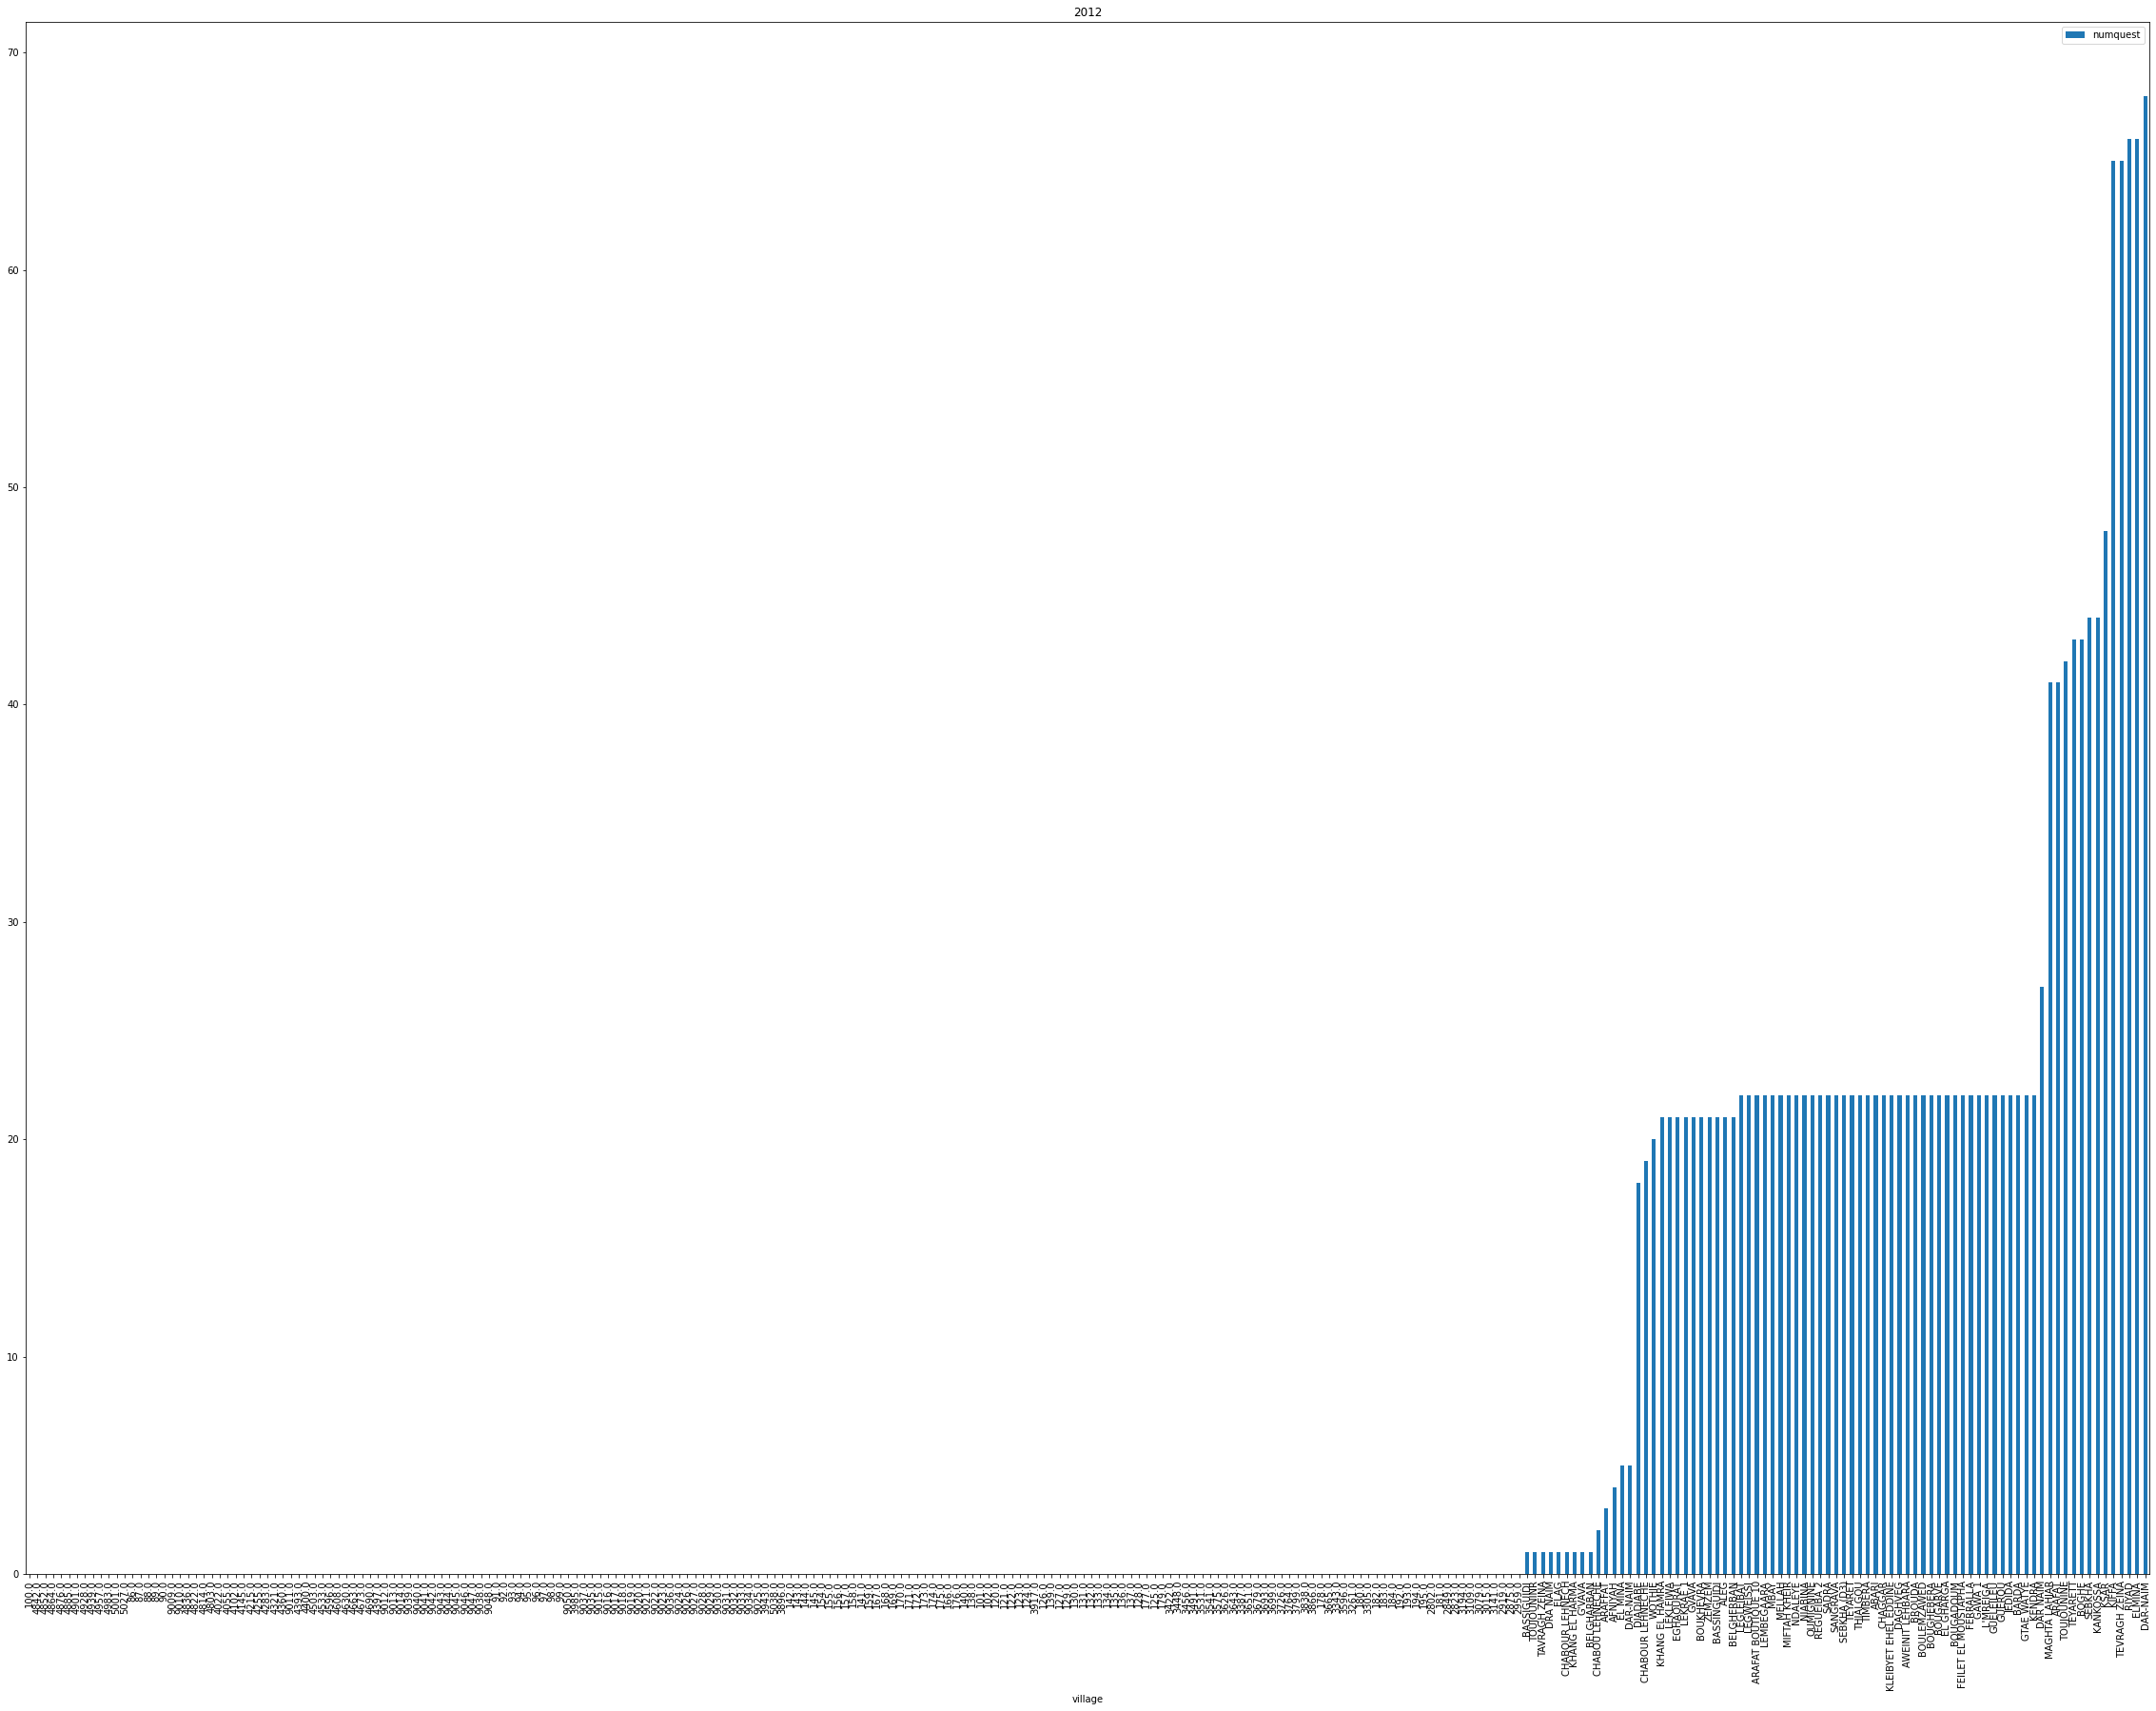

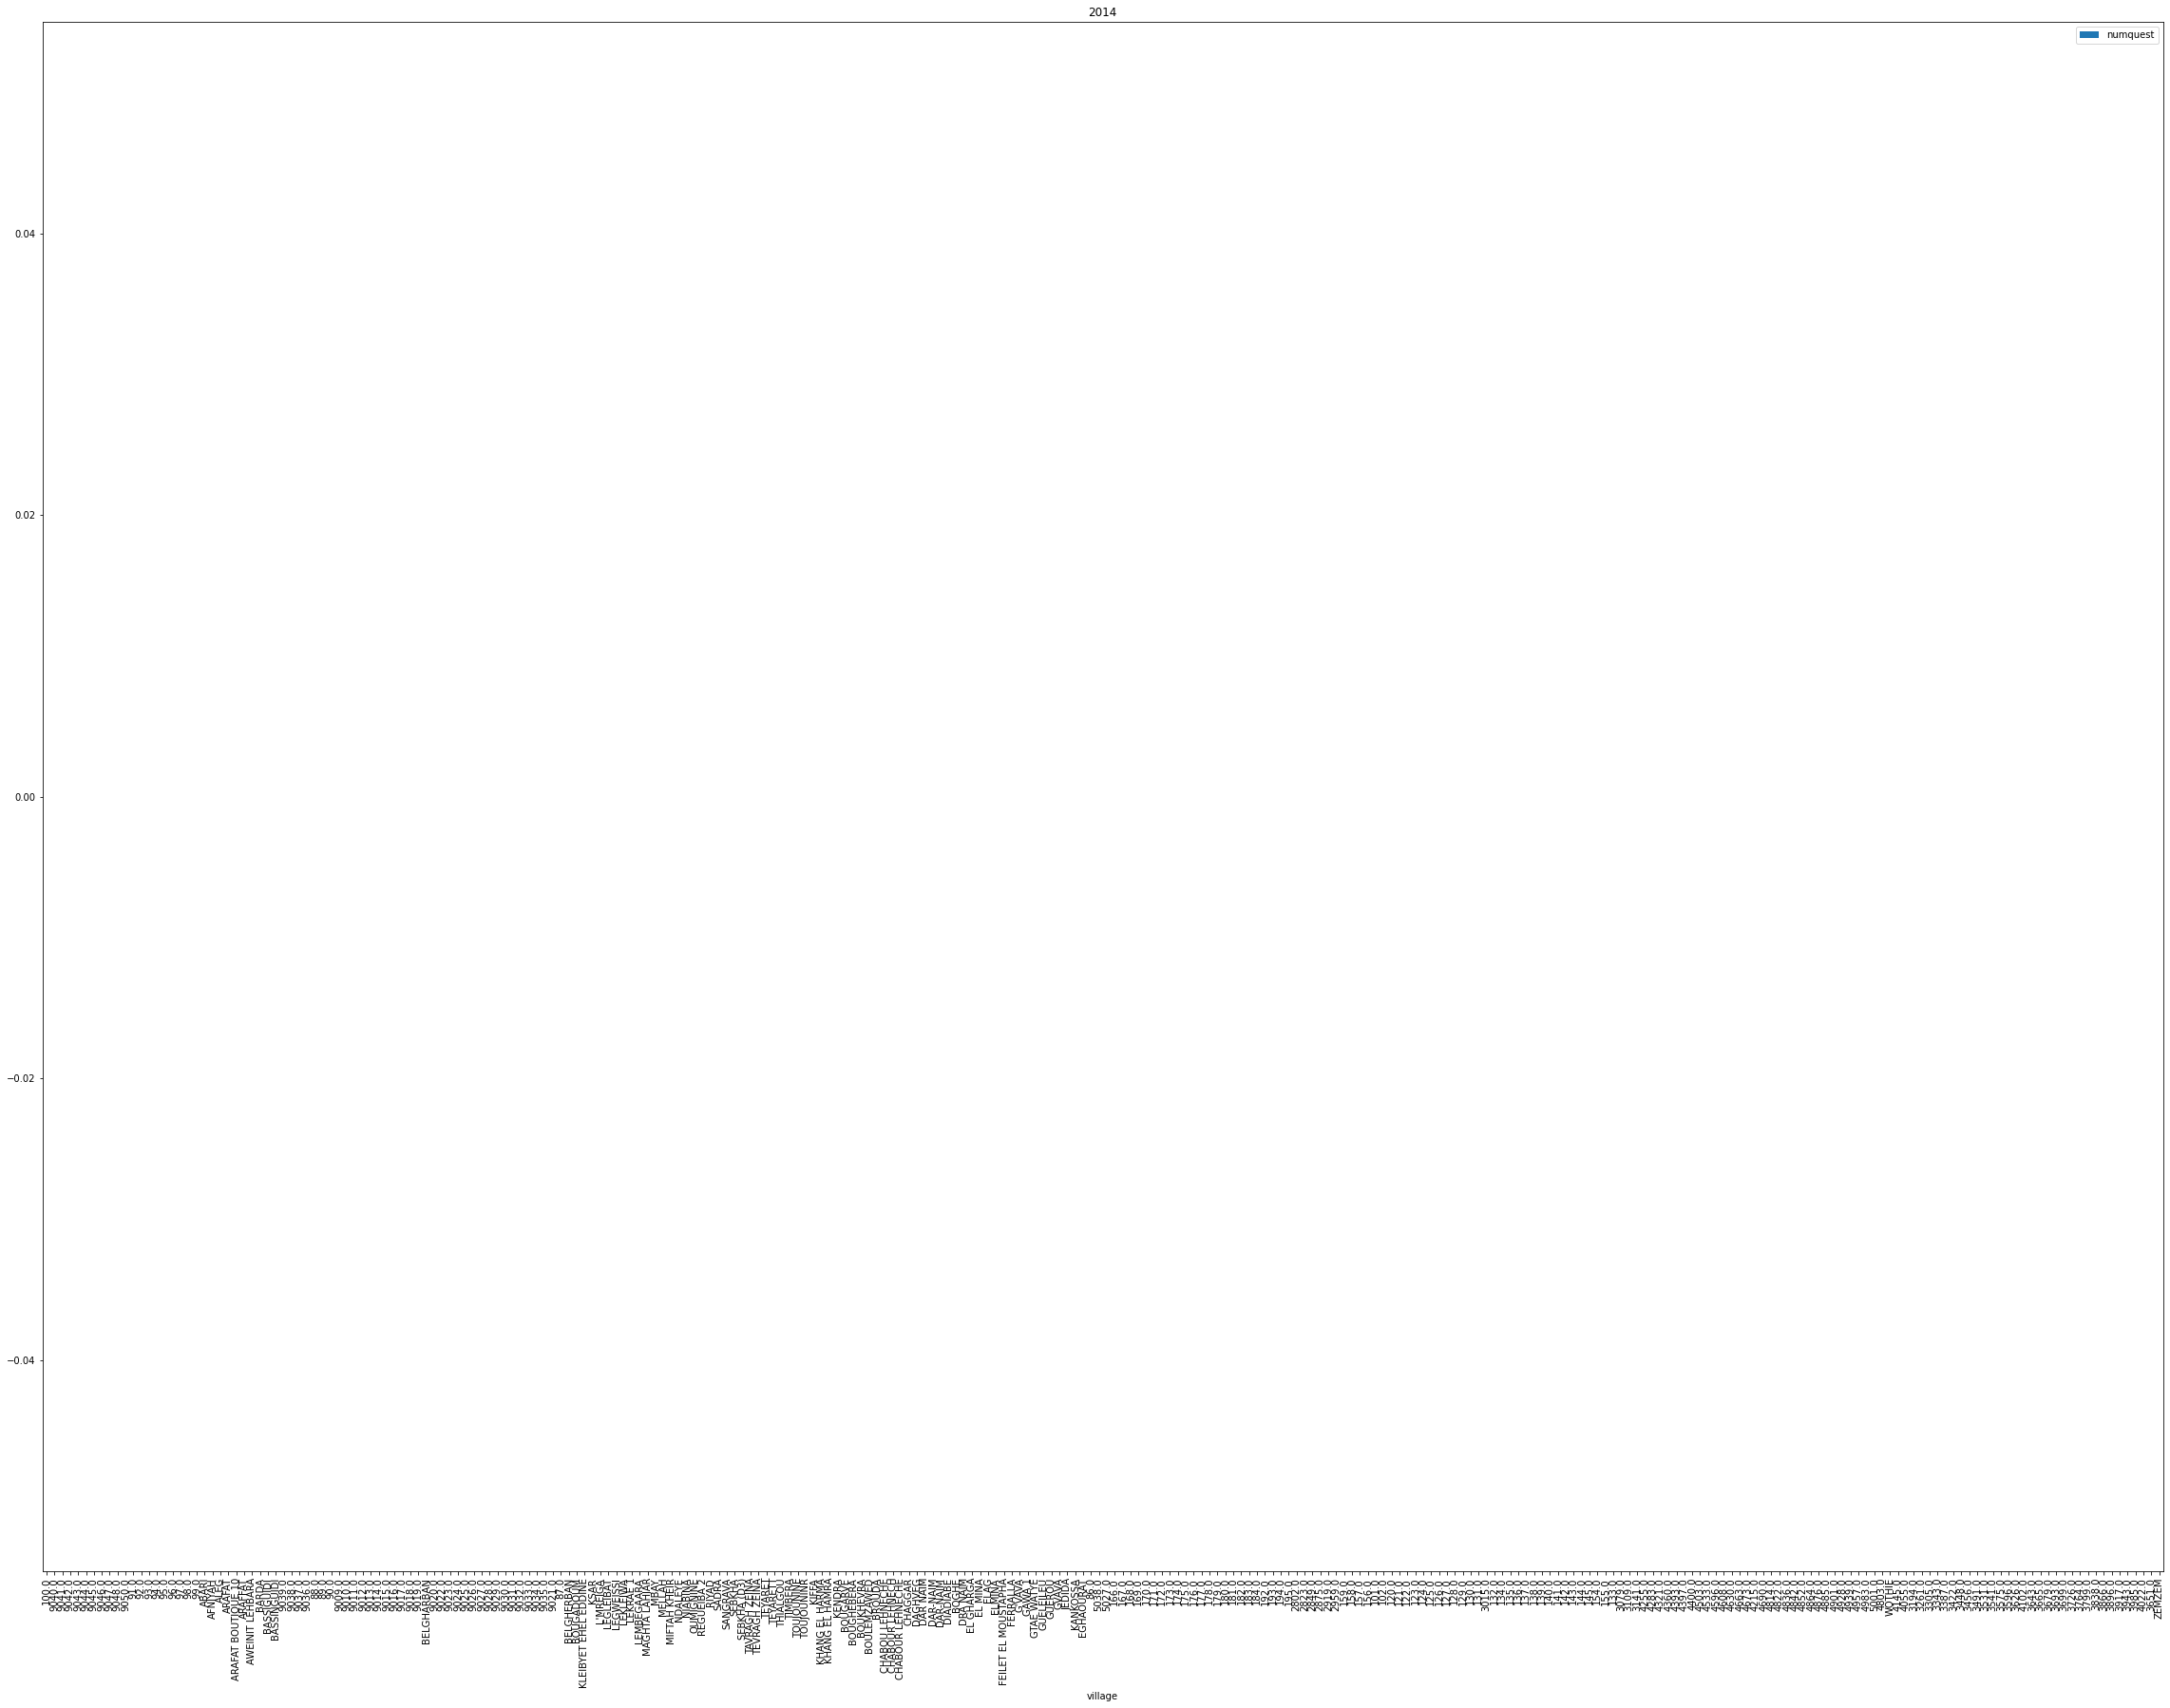

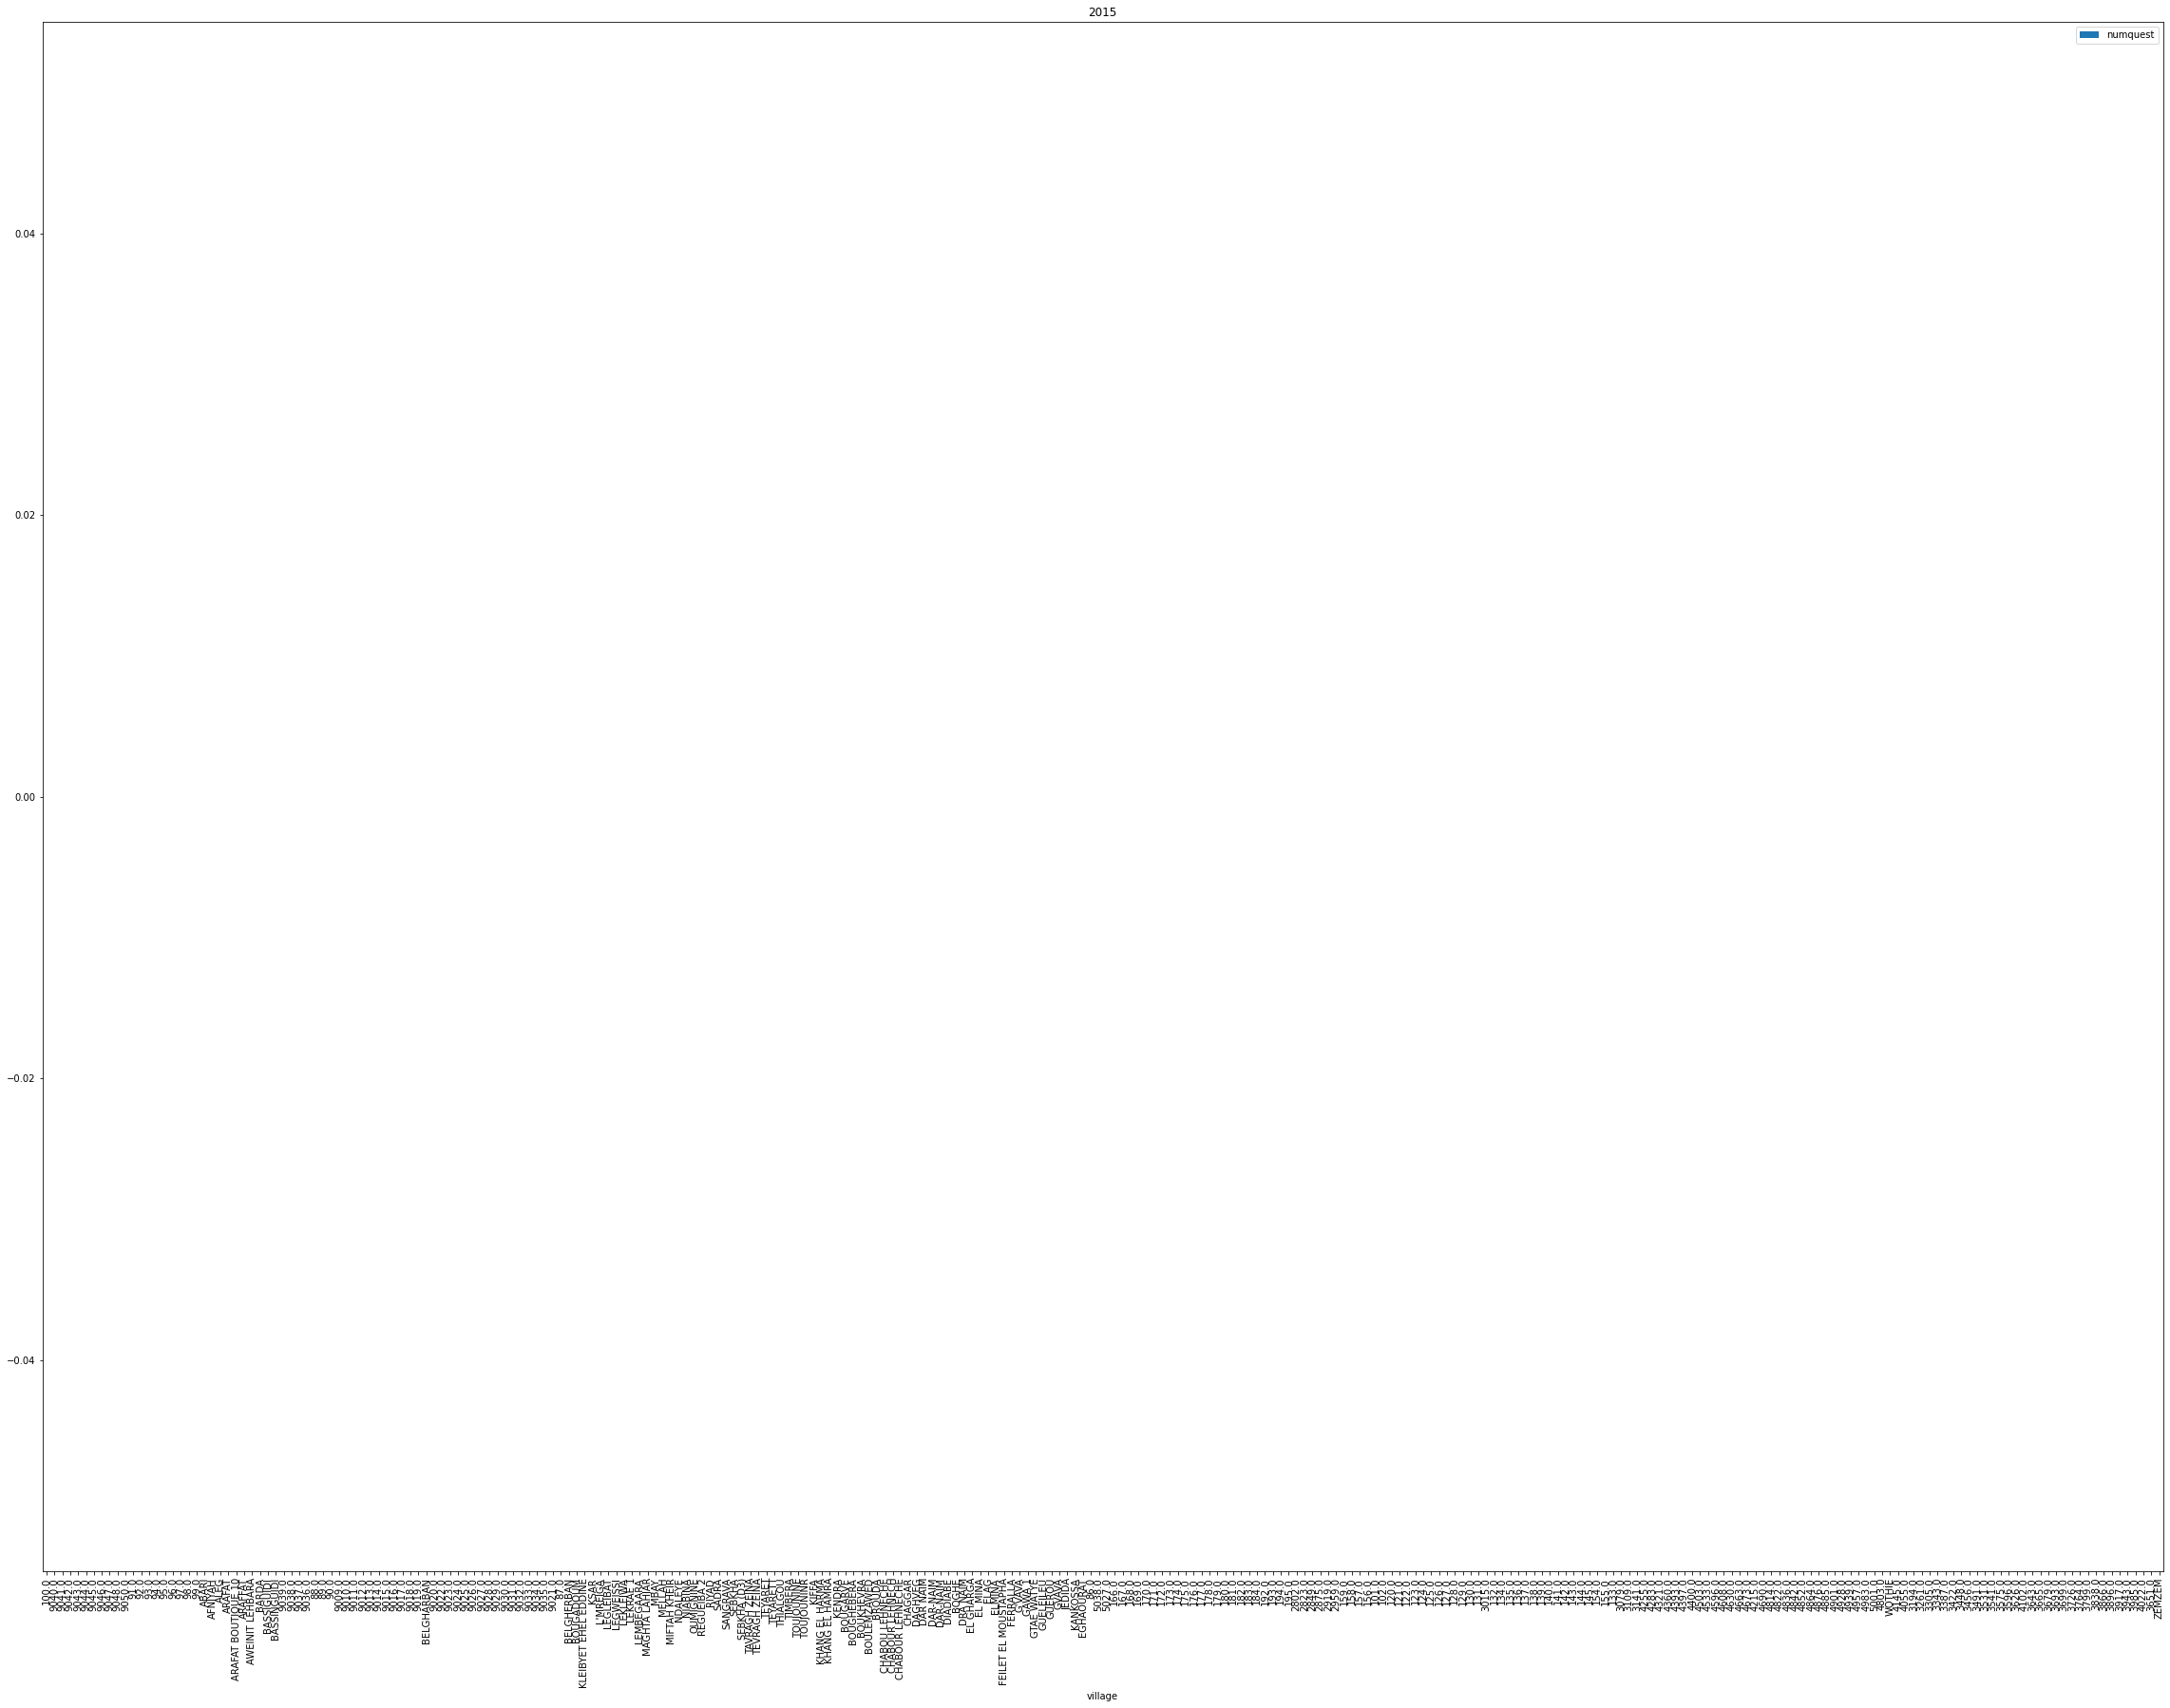

In [9]:
for year in df_aggregated_file["year"].unique():
    tmp_df = df_aggregated_file.loc[df_aggregated_file["year"]==year]
    tmp_df = pd.DataFrame(tmp_df.groupby("village").count()[["numquest"]]).sort_values(by=["numquest"])
    tmp_df.plot(kind='bar', figsize=(40, 30), title=year)

### Cross with lat-lon

#### Lat lon et villag cross

In [15]:
df_tmp = df_aggregated_file[["villag","latitude","longitude","Altitude"]]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df_tmp)

                    villag   latitude  longitude    Altitude
0                  BELLAWE        NaN        NaN         NaN
1              BOULOU DOUK        NaN        NaN         NaN
2                  BELLAWE        NaN        NaN         NaN
3                   ECHAME        NaN        NaN         NaN
4               BOURGDOUNE        NaN        NaN         NaN
5              YEWLY EDINE        NaN        NaN         NaN
6            WEL BOU KESSE        NaN        NaN         NaN
7                  BELLAWE        NaN        NaN         NaN
8            WEL BOU KESSE        NaN        NaN         NaN
9               MEIMAR BOY        NaN        NaN         NaN
10             YEWLY EDINE        NaN        NaN         NaN
11                ELJEDIDE        NaN        NaN         NaN
12               ENNEAIMEE        NaN        NaN         NaN
13           WEL BOU KESSE        NaN        NaN         NaN
14                  GOURAL        NaN        NaN         NaN
15           WEL BOU KES

In [14]:
df_tmp_grouped = pd.DataFrame(df_tmp.groupby(by=["villag"]).mean())
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df_tmp_grouped)

                      latitude  longitude  Altitude
villag                                             
 E SEBKHA                  NaN        NaN       NaN
 LOUGUE BOUDAMA            NaN        NaN       NaN
ABARI                      NaN        NaN       NaN
AFNIYAH                    NaN        NaN       NaN
AGNANE                     NaN        NaN       NaN
AIN EHEL SOUEIDY           NaN        NaN       NaN
ALEG                       NaN        NaN       NaN
AMEISSINE                  NaN        NaN       NaN
AMEJERJE                   NaN        NaN       NaN
ANCIEN SEBKHA              NaN        NaN       NaN
ARAFAT                     NaN        NaN       NaN
ARAFAT BOUTIQUE 10         NaN        NaN       NaN
ARAFFAT                    NaN        NaN       NaN
AV MBOUD                   NaN        NaN       NaN
AWEINIT LEHBARA            NaN        NaN       NaN
AWLADMENSSOUR              NaN        NaN       NaN
BARDA                      NaN        NaN       NaN
BASRA 1     

They are totally mirror. We need an overlap. Try other.

#### Lat lon et village cross


=> même constat.

In [18]:
df_tmp_2 = df_aggregated_file[["village","latitude","longitude","Altitude"]]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df_tmp_2)

                   village   latitude  longitude    Altitude
0                    123.0        NaN        NaN         NaN
1                    124.0        NaN        NaN         NaN
2                    123.0        NaN        NaN         NaN
3                    127.0        NaN        NaN         NaN
4                    136.0        NaN        NaN         NaN
5                    134.0        NaN        NaN         NaN
6                    121.0        NaN        NaN         NaN
7                    123.0        NaN        NaN         NaN
8                    121.0        NaN        NaN         NaN
9                    131.0        NaN        NaN         NaN
10                   134.0        NaN        NaN         NaN
11                   125.0        NaN        NaN         NaN
12                   128.0        NaN        NaN         NaN
13                   121.0        NaN        NaN         NaN
14                   120.0        NaN        NaN         NaN
15                   121

#### Lat lon et commune cross


communes qui sont définies par des chiffres dans les dernières années => moughataas ne sont pas définies par des chiffres => on peut au moins délimiter où sont ces communes

In [19]:
df_tmp_3 = df_aggregated_file[["commune","latitude","longitude","Altitude"]]
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(df_tmp_3)

              commune   latitude  longitude    Altitude
0              5202.0        NaN        NaN         NaN
1              5203.0        NaN        NaN         NaN
2              5202.0        NaN        NaN         NaN
3              5303.0        NaN        NaN         NaN
4              5503.0        NaN        NaN         NaN
5              5403.0        NaN        NaN         NaN
6              5103.0        NaN        NaN         NaN
7              5202.0        NaN        NaN         NaN
8              5101.0        NaN        NaN         NaN
9              5304.0        NaN        NaN         NaN
10             5403.0        NaN        NaN         NaN
11             5301.0        NaN        NaN         NaN
12             5303.0        NaN        NaN         NaN
13             5103.0        NaN        NaN         NaN
14             5101.0        NaN        NaN         NaN
15             5103.0        NaN        NaN         NaN
16             5304.0        NaN        NaN     

ENFIN UNE CORRESPONDANCE ! 

On a un overlapping communes/lat-lon.

On impute les lat-lon sur les communes.

Quand on a pas la lat-lon de la commune, on prend la moughataa associée à cette commune. 

On impute les lat-lon sur les moughataas.

#### Création de la table de match commune-lat-lon

In [85]:
commune_geo_table = pd.DataFrame(df_aggregated_file[["commune","latitude","longitude","Altitude"]].groupby(by=["commune"]).mean()).reset_index()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(commune_geo_table)

             commune   latitude  longitude    Altitude
0              104.0        NaN        NaN         NaN
1              108.0        NaN        NaN         NaN
2             1305.0        NaN        NaN         NaN
3             1306.0        NaN        NaN         NaN
4             1309.0        NaN        NaN         NaN
5              131.0        NaN        NaN         NaN
6            13101.0        NaN        NaN         NaN
7              132.0        NaN        NaN         NaN
8            13201.0        NaN        NaN         NaN
9              133.0        NaN        NaN         NaN
10           13301.0        NaN        NaN         NaN
11             134.0        NaN        NaN         NaN
12           13401.0        NaN        NaN         NaN
13             135.0        NaN        NaN         NaN
14           13501.0        NaN        NaN         NaN
15             136.0        NaN        NaN         NaN
16           13601.0        NaN        NaN         NaN
17        

#### Création de la table de match moughataa-lat-lon

In [42]:
moughataa_geo_table = pd.DataFrame(df_aggregated_file[["moughataa","latitude","longitude","Altitude"]].groupby(by=["moughataa"]).mean()).reset_index()
with pd.option_context('display.max_rows', None, 'display.max_columns', None):  
    print(moughataa_geo_table)

        moughataa   latitude  longitude    Altitude
0             1.0        NaN        NaN         NaN
1           131.0        NaN        NaN         NaN
2           133.0        NaN        NaN         NaN
3           134.0        NaN        NaN         NaN
4           135.0        NaN        NaN         NaN
5           136.0        NaN        NaN         NaN
6           137.0        NaN        NaN         NaN
7             2.0        NaN        NaN         NaN
8             3.0        NaN        NaN         NaN
9             4.0        NaN        NaN         NaN
10           41.0        NaN        NaN         NaN
11           42.0        NaN        NaN         NaN
12           43.0        NaN        NaN         NaN
13           44.0        NaN        NaN         NaN
14            5.0        NaN        NaN         NaN
15           51.0        NaN        NaN         NaN
16           52.0        NaN        NaN         NaN
17           53.0        NaN        NaN         NaN
18          

#### Groupement des deux tables de match

In [37]:
moughataas_communes = df_aggregated_file[["commune","moughataa"]].drop_duplicates().set_index("commune")
moughataas_communes_match_dict = moughataas_communes.to_dict()['moughataa']

In [68]:
def match_moughataa(commune):
    moughataa = moughataas_communes_match_dict[commune]
    return moughataa
    
commune_geo_table["moughataa"] = commune_geo_table["commune"].apply(lambda row: match_moughataa(row))

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174


ValueError: Wrong number of items passed 4, placement implies 1

In [71]:
commune_geo_table = commune_geo_table.merge(moughataa_geo_table, on="moughataa", how="left", suffixes=("","_moughataa"))

In [74]:
commune_geo_table["latitude"] = commune_geo_table["latitude"].fillna(commune_geo_table["latitude_moughataa"])
commune_geo_table["longitude"] = commune_geo_table["longitude"].fillna(commune_geo_table["longitude_moughataa"])
commune_geo_table["Altitude"] = commune_geo_table["Altitude"].fillna(commune_geo_table["Altitude_moughataa"])
commune_geo_table = commune_geo_table.drop(columns=["latitude_moughataa","longitude_moughataa","Altitude_moughataa"])

,commune,latitude,longitude,Altitude,moughataa
0,104.0,NaN,NaN,NaN,4.0
1,108.0,NaN,NaN,NaN,8.0
2,1305.0,NaN,NaN,NaN,9.0
3,1306.0,NaN,NaN,NaN,6.0
4,1309.0,NaN,NaN,NaN,9.0
...,...,...,...,...,...
169,Tifonde_Cive,15.663941,-13.173974,56.126570,Kaedi
170,Tikobra,16.141021,-12.368973,81.293775,MBout
171,Toujounine,18.065859,-15.914669,40.934002,Toujounine
172,Wali_Djantang,15.341966,-12.900133,55.999030,Maghama


#### Bilan table de match

In [ ]:
commune_geo_table

On a maximisé le nombre d'associations commune-lat-lon. On peut merge cette table avec la df d'origine pour remplir les lat-lon manquantes.

### Retour à la table principale

In [86]:
df_aggregated_file = df_aggregated_file.merge(commune_geo_table, how="left", on="commune", suffixes=("", "_geomatch"))

In [87]:
df_aggregated_file["latitude"] = df_aggregated_file["latitude"].fillna(df_aggregated_file["latitude_geomatch"])
df_aggregated_file["longitude"] = df_aggregated_file["longitude"].fillna(df_aggregated_file["longitude_geomatch"])
df_aggregated_file["Altitude"] = df_aggregated_file["Altitude"].fillna(df_aggregated_file["Altitude_geomatch"])
df_aggregated_file = df_aggregated_file.drop(columns=["latitude_geomatch","longitude_geomatch","Altitude_geomatch"])
df_aggregated_file

,numquest,ident,enqu,hors nk,moughataa,commune,villag,village,milieu,wilaya,...,Rice (imported) - Retail,Rice (local) - Retail,Sorghum (r'haya) - Retail,Sorghum (red) - Retail,Sorghum (taghalit) - Retail,Straw - Retail,Sugar - Retail,Wheat - Retail,Wheat flour - Retail,Wheat meal - Retail
0,12305.0,12305.0,Sid'ahmed Ould Brami,Hors Nouakchott,52.0,5202.0,BELLAWE,123.0,Rural,Brakna,...,210.0,181.5,NaN,NaN,233.0,NaN,280.0,149.5,NaN,NaN
1,12407.0,12407.0,Sid'ahmed Ould Brami,Hors Nouakchott,52.0,5203.0,BOULOU DOUK,124.0,Rural,Brakna,...,210.0,181.5,NaN,NaN,233.0,NaN,280.0,149.5,NaN,NaN
2,12308.0,12308.0,Sid'ahmed Ould Brami,Hors Nouakchott,52.0,5202.0,BELLAWE,123.0,Rural,Brakna,...,210.0,181.5,NaN,NaN,233.0,NaN,280.0,149.5,NaN,NaN
3,12706.0,12706.0,Sid'ahmed Ould Brami,Hors Nouakchott,53.0,5303.0,ECHAME,127.0,Rural,Brakna,...,210.0,181.5,NaN,NaN,233.0,NaN,280.0,149.5,NaN,NaN
4,13607.0,13607.0,Sid'ahmed Ould Brami,Hors Nouakchott,55.0,5503.0,BOURGDOUNE,136.0,Rural,Brakna,...,210.0,181.5,NaN,NaN,233.0,NaN,280.0,149.5,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9040,100193.0,NaN,NaN,Nouakchott,Sebkha,Sebkha,NaN,NaN,Urbain,Nouakchott,...,280.0,250.0,NaN,NaN,350.0,NaN,220.0,140.0,17.9,NaN
9041,1318114.0,NaN,NaN,Nouakchott,Ksar,Ksar,NaN,NaN,Urbain,Nouakchott,...,280.0,250.0,NaN,NaN,350.0,NaN,220.0,140.0,17.9,NaN
9042,100188.0,NaN,NaN,Nouakchott,Sebkha,Sebkha,NaN,NaN,Urbain,Nouakchott,...,280.0,250.0,NaN,NaN,350.0,NaN,220.0,140.0,17.9,NaN
9043,100195.0,NaN,NaN,Nouakchott,Sebkha,Sebkha,NaN,NaN,Urbain,Nouakchott,...,280.0,250.0,NaN,NaN,350.0,NaN,220.0,140.0,17.9,NaN


In [88]:
round(100*df_aggregated_file.isnull()["latitude"].sum()/len(df_aggregated_file),2)

28.94

#### En utilisant la colonne "commune" seulement : 

On a 26% de missing values en moins sur les latitudes/longitudes.

#### En utilisant la colonne "moughataa" en plus : 

On a 40% de missing values en moins sur les latitudes/longitudes, même si ce n'est pas très précis.

### Conclusion

Je pense qu'il faut utiliser la combinaison des deux, elles ont l'air aussi précises l'une que l'autre de toute manière quand on regarde l'étendue des lat/lon pour une moughataa et pour une commune.

On peut revérifier l'étendue des valeurs au pire mais je pense que ça sert à rien vu qu'on a pas fait varier ce que l'on a rajouté.


#### Problèmes possibles : 

ce seront des lat-lon d'endroits non enquêtés, mais l'avantage par rapport à la médiane ici c'est la continuité ... la médiane donnerait trop peu de variation dans les résultats je trouve, à discuter.